In [1]:
import time
import torch
import json
import random
import math
import warnings
import torchvision
import os
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import torchvision.models as models

from pathlib import Path
from datetime import datetime
from tqdm import tqdm
from PIL import Image
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import pairwise_distances_argmin_min, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report, precision_recall_fscore_support
from sklearn.model_selection import train_test_split, StratifiedKFold
from torch.utils.data import Subset, Dataset, DataLoader
from torchvision.models import EfficientNet
from torchvision.datasets import ImageFolder
from utils.loss_functions import tkd_kdloss

# Suppress all warnings
warnings.filterwarnings("ignore")

In [2]:
def get_next_available_dir(root_dir):
    """
    If a directory at 'root_dir' exists, append a number to create a new path.
    For example, if 'RUN' exists, this returns 'RUN_01', and so on.
    """
    if not os.path.exists(root_dir):
        return root_dir

    i = 1
    new_dir = f"{root_dir}_{str(i).zfill(2)}"

    while os.path.exists(new_dir):
        i += 1
        new_dir = f"{root_dir}_{str(i).zfill(2)}"

    return new_dir

In [3]:
# Hyperparameters
learning_rate = 0.0005 # 0.096779
epochs = 100
epochs_pretrain = 3
epochs_optimal_lr = 3
patience_teacher = 6
patience_student = 6
temperature = 4.0
alpha = 0.9
momentum = 0.9
step_size = 30
gamma = 0.1
batch_size = 64
num_workers = 4

# set to true to use stratified sampling
stratified_sampling_flag = False

# list of lambda values to loop through for grid search
lmda_list_teacher = [0]
lmda_list_student = [0]

# labels used including for plotting
class_labels = [0, 1, 3, 4, 6, 7, 11, 15, 17, 18, 19, 20, 22, 25, 27, 28, 30, 31, 33, 35, 36, 37, 39, 43, 44, 50, 51, 54, 57, 58]
class_labels_new = torch.tensor([i for i in range(len(class_labels))])
num_classes = 16
class_names_new = [f"Class {label}" for label in range(num_classes)]

# SPECIFY OUT DIR NAME
# Create directory and file path to save all outputs
directory_name = 'Smaller_Student_Models'
# This will append version to end of directory name and create new directory if already exists
output_dir = get_next_available_dir(directory_name)

os.makedirs(output_dir, exist_ok=True)

In [4]:
# Paths for subdirectories inside output_dir
models_dir = os.path.join(output_dir, 'models')
weights_dir = os.path.join(output_dir, 'weights')

# Create the subdirectories if they don't exist
os.makedirs(models_dir, exist_ok=True)
os.makedirs(weights_dir, exist_ok=True)

In [5]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters())

# Initialize EfficientNet B2
efficientnet_b2 = models.efficientnet_b2(pretrained=True)
efficientnet_b2.classifier[1] = nn.Linear(efficientnet_b2.classifier[1].in_features, num_classes)

# Initialize EfficientNet B1
efficientnet_b1 = models.efficientnet_b1(pretrained=True)
efficientnet_b1.classifier[1] = nn.Linear(efficientnet_b1.classifier[1].in_features, num_classes)

# Initialize EfficientNet B0
efficientnet_b0 = models.efficientnet_b0(pretrained=True)
efficientnet_b0.classifier[1] = nn.Linear(efficientnet_b0.classifier[1].in_features, num_classes)

# Initialize MobileNetV2
student_model_mobilenetv2 = models.mobilenet_v2(pretrained=True)
student_model_mobilenetv2.classifier[1] = nn.Linear(student_model_mobilenetv2.classifier[1].in_features, num_classes)

# Initialize ShuffleNet
student_model_shufflenet = models.shufflenet_v2_x1_0(pretrained=True)
num_features = student_model_shufflenet.fc.in_features
student_model_shufflenet.fc = nn.Linear(num_features, num_classes)

# Initialize SqueezeNet
student_model_squeezenet = models.squeezenet1_0(pretrained=True)
student_model_squeezenet.classifier[1] = nn.Conv2d(512, num_classes, kernel_size=(1,1), stride=(1,1))
student_model_squeezenet.num_classes = num_classes

class CustomSmallCNN(nn.Module):
    def __init__(self, num_classes=16):
        super(CustomSmallCNN, self).__init__()
        # Convolutional layer (input channels, output channels, kernel size)
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)

        # Pooling layer
        self.pool = nn.MaxPool2d(2, 2)

        # Adaptive pooling to make it size-agnostic
        self.adaptive_pool = nn.AdaptiveAvgPool2d((5, 5))

        # Fully connected layers
        self.fc1 = nn.Linear(32 * 5 * 5, 120)  # 5*5 is derived from the adaptive pooling size
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, num_classes)

    def forward(self, x):
        # Apply convolutions, followed by max pooling
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))

        # Adaptive pooling and flattening
        x = self.adaptive_pool(x)
        x = x.view(x.size(0), -1)

        # Apply fully connected layers
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Initialize Custom Ultra Tiny CNN
student_model_custom_small_cnn = CustomSmallCNN(num_classes=num_classes)


In [6]:
# Count parameters
total_params_efficientnet_b2 = count_parameters(efficientnet_b2)
total_params_efficientnet_b1 = count_parameters(efficientnet_b1)
total_params_efficientnet_b0 = count_parameters(efficientnet_b0)
total_params_mobilenetv2 = count_parameters(student_model_mobilenetv2)
total_params_shufflenet = count_parameters(student_model_shufflenet)
total_params_squeezenet = count_parameters(student_model_squeezenet)
total_params_custom_small_cnn = count_parameters(student_model_custom_small_cnn)

print(f"EfficientNet B2 Total Parameters: {total_params_efficientnet_b2}")
print(f"EfficientNet B1 Total Parameters: {total_params_efficientnet_b1}")
print(f"EfficientNet B0 Total Parameters: {total_params_efficientnet_b0}")
print(f"MobileNetV2 Total Parameters: {total_params_mobilenetv2}")
print(f"ShuffleNet Total Parameters: {total_params_shufflenet}")
print(f"SqueezeNet Total Parameters: {total_params_squeezenet}")
print(f"Custom Small CNN Total Parameters: {total_params_custom_small_cnn}")


EfficientNet B2 Total Parameters: 7723538
EfficientNet B1 Total Parameters: 6533680
EfficientNet B0 Total Parameters: 4028044
MobileNetV2 Total Parameters: 2244368
ShuffleNet Total Parameters: 1270004
SqueezeNet Total Parameters: 743632
Custom Small CNN Total Parameters: 112732


In [7]:
# List of models
student_models = [
    efficientnet_b2, 
    efficientnet_b1, 
    efficientnet_b0, 
    student_model_mobilenetv2, 
    student_model_shufflenet, 
    student_model_squeezenet,
    student_model_custom_small_cnn
]


In [8]:
# set device to cuda if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Check if CUDA is available
cuda_available = torch.cuda.is_available()

# Count the number of GPUs available
num_gpus = torch.cuda.device_count()

print("CUDA Available:", cuda_available)
print("Number of GPUs:", num_gpus)

torch.cuda.empty_cache()

CUDA Available: True
Number of GPUs: 1


In [9]:
# Assuming your JSON file is named 'your_file.json'
file_path = './WIDER/Annotations/wider_attribute_trainval.json'

with open(file_path, 'r') as file:
    # Load the JSON data from the file
    data = json.load(file)

class_idx = data['scene_id_map']

In [10]:
new_label_mapping = {
    0: "Team_Sports",
    1: "Celebration",
    2: "Parade",
    3: "Waiter_Or_Waitress",
    4: "Individual_Sports",
    5: "Surgeons",
    6: "Spa",
    7: "Law_Enforcement",
    8: "Business",
    9: "Dresses",
    10: "Water_Activities",
    11: "Picnic",
    12: "Rescue",
    13: "Cheering",
    14: "Performance_And_Entertainment",
    15: "Family"
}

# Ensure that all 16 new classes are covered
# If some classes are not explicitly mentioned in new_label_mapping, add them
for i in range(num_classes):
    if i not in new_label_mapping:
        new_label_mapping[i] = "Additional Category {}".format(i)

class_idx = new_label_mapping

In [11]:
class StratifiedBatchSampler:
    """Stratified batch sampling
    Provides equal representation of target classes in each batch
    """
    def __init__(self, y, batch_size, shuffle=True):
        if torch.is_tensor(y):
            y = y.numpy()
        assert len(y.shape) == 1, 'label array must be 1D'
        n_batches = int(len(y) / batch_size)
        self.skf = StratifiedKFold(n_splits=n_batches, shuffle=shuffle)
        self.X = torch.randn(len(y),1).numpy()
        self.y = y
        self.shuffle = shuffle
        self.batch_size = batch_size

    def __iter__(self):
        if self.shuffle:
            self.skf.random_state = torch.randint(0,int(1e8),size=()).item()
        for train_idx, test_idx in self.skf.split(self.X, self.y):
            yield test_idx

    def __len__(self):
        return len(self.y)//self.batch_size

In [12]:
class DataSet(Dataset):
    def __init__(self, ann_files, augs, img_size, dataset):

        # Create a mapping from old labels to new labels
        self.label_mapping = {old_label: new_label for new_label, old_label in enumerate(sorted(class_labels))}

        self.new_label_mapping = {
            0: 2,  # Parade
            1: 8,  # Business
            2: 7,  # Law Enforcement
            3: 14,  # Performance and Entertainment
            4: 1,  # Celebration
            5: 13,  # Cheering
            6: 8,  # Business
            7: 8,  # Business
            8: 1,  # Celebration
            9: 14,  # Performance and Entertainment
            10: 15, # Family
            11: 15, # Family
            12: 11, # Picnic
            13: 7, # Law Enforcement
            14: 6, # Spa
            15: 13, # Cheering
            16: 5, # Surgeons
            17: 3, # Waiter or Waitress
            18: 4, # Individual Sports
            19: 0, # Team Sports
            20: 0, # Team Sports
            21: 0, # Team Sports
            22: 4, # Individual Sports
            23: 10, # Water Activities
            24: 4, # Individual Sports
            25: 1, # Celebration
            26: 9, # Dresses
            27: 12, # Rescue
            28: 10,# Water Activities
            29: 0  # Team Sports
        }

        self.dataset = dataset
        self.ann_files = ann_files
        self.augment = self.augs_function(augs, img_size)
        # Initialize transformations directly
        self.transform = transforms.Compose(
            [
                transforms.ToTensor(),
                transforms.Normalize(mean=[0, 0, 0], std=[1, 1, 1])
            ] 
        )
        if self.dataset == "wider":
            self.transform = transforms.Compose(
                [
                    transforms.ToTensor(),
                    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])                ] 
            )        

        self.anns = []
        self.load_anns()
        print(self.augment)

    def augs_function(self, augs, img_size):            
        t = []
        if 'randomflip' in augs:
            t.append(transforms.RandomHorizontalFlip())
        if 'ColorJitter' in augs:
            t.append(transforms.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5, hue=0))
        if 'resizedcrop' in augs:
            t.append(transforms.RandomResizedCrop(img_size, scale=(0.7, 1.0)))
        if 'RandAugment' in augs:
            t.append(transforms.RandAugment())

        t.append(transforms.Resize((img_size, img_size)))

        return transforms.Compose(t)
    
    def load_anns(self):
        self.anns = []
        for ann_file in self.ann_files:
            json_data = json.load(open(ann_file, "r"))
            self.anns += json_data

    def __len__(self):
        return len(self.anns)

    def __getitem__(self, idx):
        # Make sure the index is within bounds
        idx = idx % len(self)
        ann = self.anns[idx]
        
        try:
            # Attempt to open the image file
            img = Image.open(f'WIDER/Image/{ann["file_name"]}').convert("RGB")

            # If this is the wider dataset, proceed with specific processing
            # x, y, w, h = ann['bbox']
            # img_area = img.crop([x, y, x+w, y+h])
            img_area = self.augment(img)
            img_area = self.transform(img_area)
            attributes_list = [target['attribute'] for target in ann['targets']]
            num_people = len(attributes_list)
            attributes_distribution = [max(sum(attribute), 0)/num_people for attribute in zip(*attributes_list)]
            # Extract label from image path
            img_path = f'WIDER/Image/{ann["file_name"]}'
            label = self.extract_label(img_path)  # You might need to implement this method
            
            return {
                "label": label,
                "target": torch.tensor([attributes_distribution[0]], dtype=torch.float32),
                "img": img_area
            }
            
        except Exception as e:
            # If any error occurs during the processing of an image, log the error and the index
            print(f"Error processing image at index {idx}: {e}")
            # Instead of returning None, raise the exception
            raise

    def extract_label(self, img_path):
        original_label = None
    
        if "WIDER/Image/train" in img_path:
            label_str = img_path.split("WIDER/Image/train/")[1].split("/")[0]
            original_label = int(label_str.split("--")[0])
        elif "WIDER/Image/test" in img_path:
            label_str = img_path.split("WIDER/Image/test/")[1].split("/")[0]
            original_label = int(label_str.split("--")[0])
        elif "WIDER/Image/val" in img_path:  # Handle validation images
            label_str = img_path.split("WIDER/Image/val/")[1].split("/")[0]
            original_label = int(label_str.split("--")[0])
    
        if original_label is not None:
            remapped_label = self.label_mapping[original_label]
            new_label_mapping = self.new_label_mapping[remapped_label]
            return new_label_mapping
        else:
            raise ValueError(f"Label could not be extracted from path: {img_path}")


In [13]:
train_file = ['data/wider/trainval_wider.json']
test_file = ['data/wider/test_wider.json']


In [14]:
def custom_collate(batch):
    # Filter out any None items in the batch
    batch = [item for item in batch if item is not None]
    # If after filtering the batch is empty, handle this case by either returning an empty tensor or raising an exception
    if len(batch) == 0:
        raise ValueError("Batch is empty after filtering out None items.")
    return torch.utils.data.dataloader.default_collate(batch)


In [15]:
# train_dataset = DataSet(train_file, augs = ['RandAugment'], img_size = 226, dataset = 'wider')
train_dataset = DataSet(train_file, augs = [], img_size = 226, dataset = 'wider')
test_dataset = DataSet(test_file, augs = [], img_size = 226, dataset = 'wider')

if stratified_sampling_flag:
    trainloader = DataLoader(train_dataset, 
                             batch_sampler=StratifiedBatchSampler(torch.tensor([train_dataset[i]['label'] for i in range(len(train_dataset))]), 
                             batch_size=batch_size), num_workers=num_workers, collate_fn=custom_collate)
    testloader = DataLoader(test_dataset, batch_sampler=StratifiedBatchSampler(torch.tensor([test_dataset[i]['label'] for i in range(len(test_dataset))]), 
                             batch_size=batch_size), num_workers=num_workers, collate_fn=custom_collate)
else:
    trainloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, 
                             num_workers=num_workers, collate_fn=custom_collate)
    testloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers, collate_fn=custom_collate)


Compose(
    Resize(size=(226, 226), interpolation=bilinear, max_size=None, antialias=warn)
)
Compose(
    Resize(size=(226, 226), interpolation=bilinear, max_size=None, antialias=warn)
)


In [16]:
len(train_dataset)

10324

In [17]:
# def print_batch_class_counts(data_loader, label_mapping, num_batches=5):
#     for i, batch in enumerate(data_loader):
#         if i >= num_batches:
#             break

#         # Extract labels from the batch
#         labels = batch['label']

#         # Count occurrences of each class
#         class_counts = torch.bincount(labels)

#         # Map class counts to class names
#         class_counts_with_names = {label_mapping.get(j, f"Unknown Class {j}"): class_counts[j].item() for j in range(len(class_counts))}

#         # Print class counts and total observations
#         print(f"Batch {i + 1}:")
#         for class_name, count in class_counts_with_names.items():
#             print(f"    {class_name}: {count}")
#         print(f"Total Observations: {len(labels)}\n")

# print_batch_class_counts(trainloader, new_label_mapping)


# Start Training Process

In [18]:
def one_hot_encode(labels, num_classes):
    return np.eye(num_classes)[labels]

def calculate_recall_multiclass(conf_matrix):
    recalls = np.diag(conf_matrix) / np.sum(conf_matrix, axis=1)
    recalls[np.isnan(recalls)] = 0  # Replace NaN with 0
    return recalls

def evaluate_model_with_gender_multiclass(pred, label, gender, num_classes):
    predictions = pred.cpu()
    true_labels = label.cpu()
    gender = gender.cpu()

    # Identify male and female indices based on the gender threshold
    male_indices = np.where(gender >= 0.5)[0]
    female_indices = np.where(gender < 0.5)[0]

    # Convert labels to one-hot encoding
    one_hot_labels = one_hot_encode(true_labels, num_classes=num_classes)
    one_hot_preds = one_hot_encode(predictions, num_classes=num_classes)
    # Initialize recall arrays
    male_recall = np.zeros(num_classes)
    female_recall = np.zeros(num_classes)

    # Extract predictions and labels for male and female indices
    male_predictions = np.argmax(one_hot_preds[male_indices], axis=1)
    female_predictions = np.argmax(one_hot_preds[female_indices], axis=1)
    male_labels = np.argmax(one_hot_labels[male_indices], axis=1)
    female_labels = np.argmax(one_hot_labels[female_indices], axis=1)

    # Check if the class labels are within the expected range
    assert (0 <= male_predictions.min() < num_classes) and (0 <= male_predictions.max() < num_classes), "Invalid class indices in male predictions"
    assert (0 <= female_predictions.min() < num_classes) and (0 <= female_predictions.max() < num_classes), "Invalid class indices in female predictions"
    assert (0 <= male_labels.min() < num_classes) and (0 <= male_labels.max() < num_classes), "Invalid class indices in male labels"
    assert (0 <= female_labels.min() < num_classes) and (0 <= female_labels.max() < num_classes), "Invalid class indices in female labels"

    # Calculate confusion matrices for each gender
    male_conf_matrix = confusion_matrix(male_labels, male_predictions, labels=np.arange(num_classes))
    female_conf_matrix = confusion_matrix(female_labels, female_predictions, labels=np.arange(num_classes))

    # Calculate recall for each class and gender
    male_recall[:len(male_conf_matrix)] = calculate_recall_multiclass(male_conf_matrix)
    female_recall[:len(female_conf_matrix)] = calculate_recall_multiclass(female_conf_matrix)

    return male_recall - female_recall, male_conf_matrix, female_conf_matrix

In [19]:
# Instantiate the models
###################### Testing 1 ######################
# Create instances of your models
teacher_model = torchvision.models.efficientnet_b3(weights='DEFAULT')
teacher_model.classifier = nn.Linear(1536, num_classes)
student_model = torchvision.models.efficientnet_b0(weights='DEFAULT')
student_model.classifier = nn.Linear(1280, num_classes)


This is the initialization of the 2-layer Adversary Perceptron. It is initialized with the number of classes*2, which represents the predicted labels (y_hat) and the true labels (y). The output of the final layer is a regression output, which is intended to predict the strength of gender (continuous number where anything past 0.5 is more male).


In [20]:
class Adversary(nn.Module):
    def __init__(self, input_size=num_classes):
        super(Adversary, self).__init__()

        self.a1 = nn.Linear(input_size, 16)
        self.a2 = nn.Linear(16, 1)  # Output size 1 for regression
        nn.init.xavier_normal_(self.a1.weight)
        nn.init.kaiming_normal_(self.a2.weight, mode='fan_out', nonlinearity='relu')

    def forward(self, input_ids):
        adversary = F.relu(self.a1(input_ids))
        adversary_output = F.sigmoid(self.a2(adversary))  # Linear activation for regression
        return adversary_output

# Instantiate the Adversary
adv = Adversary()


In [21]:
def pretrain_student(student, teacher, trainloader, criterion, optimizer, device, alpha, temperature, epochs_pretrain, patience=patience_student):
    teacher.eval()
    teacher.to(device)
    best_val_loss = float('inf')  
    patience_counter = 0 
    student_epoch_losses = []
    val_losses = []
    
    for epoch in range(epochs_pretrain):
        student.train()
        student.to(device)
        running_loss = 0.0 
        epoch_loss = 0.0  
        num_batches = 0  
        
        for index, data in enumerate(tqdm(trainloader)):

            inputs = data['img'].to(device)
            labels = data['label'].to(device)
            optimizer.zero_grad()
            student_outputs = student(inputs)

            with torch.no_grad():
                teacher_outputs = teacher(inputs)

            ce_loss = criterion(student_outputs, labels)
            kd_loss = tkd_kdloss(student_outputs, teacher_outputs, temperature=temperature)  # Make sure this returns a scalar
            
            # If not scalar, sum up to make sure the loss is scalar
            if kd_loss.ndim != 0:
                kd_loss = kd_loss.sum()
                
            # Now combine the losses
            loss = alpha * kd_loss + (1 - alpha) * ce_loss
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            epoch_loss += loss.item()
            num_batches += 1
        
        epoch_loss /= num_batches
        print(f'*******Epoch {epoch}: loss - {epoch_loss}')
        student_epoch_losses.append(epoch_loss)

In [22]:
def pretrain_teacher(teacher, trainloader, criterion, optimizer, device, epochs_pretrain, patience=patience_student):
    teacher.to(device)
    teacher.train()  # Set the model to training mode
    best_val_loss = float('inf')  
    patience_counter = 0 
    teacher_epoch_losses = []
    val_losses = []
    
    for epoch in range(epochs_pretrain):
        running_loss = 0.0 
        epoch_loss = 0.0  
        num_batches = 0  
        
        for index, data in enumerate(tqdm(trainloader)):
            inputs = data['img'].to(device)
            labels = data['label'].to(device)
            optimizer.zero_grad()
            teacher_outputs = teacher(inputs)

            ce_loss = criterion(teacher_outputs, labels)
                
            loss = ce_loss
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            epoch_loss += loss.item()
            num_batches += 1
        
        epoch_loss /= num_batches
        print(f'*******Epoch {epoch}: loss - {epoch_loss}')
        teacher_epoch_losses.append(epoch_loss)

In [23]:
def pretrain_adversary(adv, student, adversary_optimizer, trainloader, adv_criterion, device, epochs_pretrain):

  for epoch in range(epochs_pretrain):
    epoch_loss = 0
    epoch_batches = 0
    for i, data in enumerate(tqdm(trainloader)): # starting from the 0th batch
        # get the inputs and labels
        adv.train()
        adv.to(device)
        inputs = data['img'].to(device)
        labels = data['label'].to(device)
        targets = data['target'].to(device)
        student = student.to(device)
        adversary_optimizer.zero_grad()
        student_output = student(inputs)
        adversary_output = adv(student_output)
        adversary_loss = adv_criterion(adversary_output, targets) # compute loss
        adversary_loss.backward() # back prop
        adversary_optimizer.step()
        epoch_loss += adversary_loss.item()
        epoch_batches += 1

    print("Average Pretrain Adversary epoch loss: ", epoch_loss/epoch_batches)

In [24]:
# Optimizer and scheduler for the student model
student_optimizer = optim.Adam(student_model.parameters(), lr=learning_rate)

# Optimizer and scheduler for the teacher model
teacher_optimizer = optim.SGD(teacher_model.parameters(), lr=learning_rate, momentum=momentum)
teacher_scheduler = torch.optim.lr_scheduler.StepLR(teacher_optimizer, step_size=step_size, gamma=gamma)

optimizer_adv = optim.Adam(adv.parameters(), lr=learning_rate)

# Instantiate the model and the loss function
criterion_clf = nn.CrossEntropyLoss()
adv_criterion = nn.MSELoss()

In [25]:
# #### finding the optimal learning rate
# def train_teacher_optimal_lr(model, trainloader, criterion, optimizer, scheduler, device, epochs_optimal_lr=5, lr_range=(1e-4, 1e-1), plot_loss=True):
#     model.train()
#     model.to(device)
#     lr_values = np.logspace(np.log10(lr_range[0]), np.log10(lr_range[1]), epochs_optimal_lr * len(trainloader))  # Generate learning rates for each batch
#     lr_iter = iter(lr_values)
#     losses = []
#     lrs = []
    
#     for epoch in range(epochs_optimal_lr):
#         for i, batch in enumerate(tqdm(trainloader)):
#             lr = next(lr_iter)
#             for param_group in optimizer.param_groups:
#                 param_group['lr'] = lr  # Set new learning rate
            
#             inputs, labels = batch['img'].to(device), batch['label'].to(device)
#             optimizer.zero_grad()
#             outputs = model(inputs)
#             loss = criterion(outputs, labels)
#             loss.backward()
#             optimizer.step()
            
#             losses.append(loss.item())
#             lrs.append(lr)
    
#     # Calculate the derivative of the loss
#     loss_derivative = np.gradient(losses)
    
#     # Find the learning rate corresponding to the minimum derivative (steepest decline)
#     best_lr_index = np.argmin(loss_derivative)
#     best_lr = lrs[best_lr_index]
    
#     if plot_loss:
#         import matplotlib.pyplot as plt
#         plt.figure()
#         plt.plot(lrs, losses)
#         plt.xscale('log')
#         plt.xlabel('Learning Rate')
#         plt.ylabel('Loss')
#         plt.title('Learning Rate Range Test - Teacher')
#         plt.axvline(x=best_lr, color='red', linestyle='--', label=f'Best LR: {best_lr}')
#         plt.legend()
#         plt.show()
    
#     print(f'Best Learning Rate Teacher: {best_lr}')
#     return best_lr

# ############# input ############## 
# best_lr_teacher = train_teacher_optimal_lr(teacher_model, trainloader, criterion_clf, teacher_optimizer, teacher_scheduler, device, epochs_optimal_lr)  
# print(best_lr_teacher)


In [26]:
# #### finding the optimal learning rate
# def train_student_optimal_lr(model, trainloader, criterion, optimizer, device, epochs_optimal_lr=5, lr_range=(1e-4, 1e-1), plot_loss=True):
#     model.train()
#     model.to(device)
#     lr_values = np.logspace(np.log10(lr_range[0]), np.log10(lr_range[1]), epochs_optimal_lr * len(trainloader))  # Generate learning rates for each batch
#     lr_iter = iter(lr_values)
#     losses = []
#     lrs = []
    
#     for epoch in range(epochs_optimal_lr):
#         for i, batch in enumerate(tqdm(trainloader)):
#             lr = next(lr_iter)
#             for param_group in optimizer.param_groups:
#                 param_group['lr'] = lr  # Set new learning rate
            
#             inputs, labels = batch['img'].to(device), batch['label'].to(device)
#             optimizer.zero_grad()
#             outputs = model(inputs)
#             loss = criterion(outputs, labels)
#             loss.backward()
#             optimizer.step()
            
#             losses.append(loss.item())
#             lrs.append(lr)
    
#     # Calculate the derivative of the loss
#     loss_derivative = np.gradient(losses)
    
#     # Find the learning rate corresponding to the minimum derivative (steepest decline)
#     best_lr_index = np.argmin(loss_derivative)
#     best_lr = lrs[best_lr_index]
    
#     if plot_loss:
#         import matplotlib.pyplot as plt
#         plt.figure()
#         plt.plot(lrs, losses)
#         plt.xscale('log')
#         plt.xlabel('Learning Rate')
#         plt.ylabel('Loss')
#         plt.title('Learning Rate Range Test - Student')
#         plt.axvline(x=best_lr, color='red', linestyle='--', label=f'Best LR: {best_lr}')
#         plt.legend()
#         plt.show()
    
#     print(f'Best Learning Rate Student: {best_lr}')
#     return best_lr

# ############# input ############## 
# best_lr_student = train_student_optimal_lr(student_model, trainloader, criterion_clf, student_optimizer, device, epochs_optimal_lr)  
# print(best_lr_student)

In [27]:
best_lr_student = learning_rate
best_lr_teacher = learning_rate

In [28]:
def plot_loss_curve(losses):
    epochs = range(1, len(losses) + 1)
    plt.plot(epochs, losses)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Val Loss Curve')
    plt.show()

In [29]:
def train_teacher(model, adv, trainloader, criterion, adv_criterion, optimizer, optimizer_adv, device, 
                  epochs, lmda, patience=patience_teacher):

    best_val_loss = float('inf')
    patience_counter = 0
    epoch_losses = [] 
    val_losses = []
    val_disparities = []
    val_accuracies = []
    best_total_val_loss = float('inf')

    for epoch in range(epochs):
        model.train()
        adv.train()
        model.to(device)
        adv.to(device)
        running_loss = 0.0
        epoch_loss = 0.0  
        num_batches = 0  
        
        for index, data in enumerate(tqdm(trainloader)):
            inputs = data['img'].to(device)
            labels = data['label'].to(device)
            targets = data['target'].to(device)
        
            # Forward pass for teacher model
            optimizer.zero_grad()
            outputs = model(inputs)
            classification_loss = criterion(outputs, labels)
        
            # Forward pass for adversary model
            optimizer_adv.zero_grad()
            with torch.no_grad():
                teacher_outputs_detached = outputs.detach()
            adversary_output = adv(teacher_outputs_detached)
            adversary_loss = adv_criterion(adversary_output, targets)
        
            # Calculate the total loss by combining classification and adversary loss
            if lmda != 0:
                total_loss = classification_loss + classification_loss/adversary_loss - lmda * adversary_loss
            else:
                total_loss = classification_loss
                
            total_loss.backward()
        
            optimizer.step()
            optimizer_adv.step()
        
            running_loss += total_loss.item()
            epoch_loss += total_loss.item()
            num_batches += 1

        epoch_loss /= num_batches  
        epoch_losses.append(epoch_loss)

        model.eval()
        total_correct = 0
        total_samples = 0
        total_val_loss = 0.0
        num_batches = 0
        confusion_male = np.zeros((num_classes, num_classes))
        confusion_female = np.zeros((num_classes, num_classes))
        
        with torch.no_grad():
            for val_data in tqdm(testloader):
                val_inputs = val_data['img'].to(device)
                val_labels = val_data['label'].to(device)
                val_targets = val_data['target'].to(device)
                
                val_outputs = model(val_inputs)
                with torch.no_grad():
                    teacher_outputs_detached_val = val_outputs.detach()                
                adversary_output_val = adv(teacher_outputs_detached_val)
                adversary_loss_val = adv_criterion(adversary_output_val, val_targets)
                
                # Compute validation loss
                val_ce_loss = criterion(val_outputs, val_labels)

                if lmda !=0:
                    val_loss = val_ce_loss + val_ce_loss/adversary_loss_val - lmda * adversary_loss_val
                else:
                    val_loss = val_ce_loss
                    
                total_val_loss += val_loss.item()

                # Compute the validation accuracy
                _, predicted = torch.max(val_outputs, 1)
                total_samples += val_labels.size(0)
                total_correct += (predicted == val_labels).sum().item()
                num_batches += 1

                # Compute recall differences for gender
                recall_diff = evaluate_model_with_gender_multiclass(predicted, val_labels, val_targets, num_classes=num_classes)
                confusion_male += recall_diff[1]
                confusion_female += recall_diff[2]

            total_val_loss /= num_batches
            confusion_male /= num_batches
            confusion_female /= num_batches
            
            epoch_disparity = calculate_recall_multiclass(confusion_male) - calculate_recall_multiclass(confusion_female)
            val_losses.append(total_val_loss)
            non_zero_abs_values = np.abs(epoch_disparity[epoch_disparity != 0])
            mean_non_zero_abs_disparity = np.mean(non_zero_abs_values)
            val_disparities.append(mean_non_zero_abs_disparity)
            accuracy = total_correct / total_samples
            val_accuracies.append(accuracy)
            class_recall_mapping = {class_name: epoch_disparity[int(class_label)] for class_label, class_name in class_idx.items()}

            print(f'*****Epoch {epoch + 1}/{epochs}*****\n' 
            f'*****Train Loss: {epoch_loss: .6f} Val Loss: {total_val_loss: .6f}*****\n'
            f'*****Validation Accuracy: {accuracy * 100:.2f}%*****\n'
            f'*****Total Avg Disparity: {mean_non_zero_abs_disparity}*****\n')
            
            # Print disparities by class label
            for class_label, recall_diff in class_recall_mapping.items():
                print(f"Class {class_label}: Recall Difference = {recall_diff}")

        # Check for early stopping
        if abs(total_val_loss) < abs(best_total_val_loss):
            best_total_val_loss = total_val_loss
            patience_counter = 0 
            best_epoch_mean_abs_disparity = mean_non_zero_abs_disparity

            # Save the teacher model and its state to the 'output_dir'
            teacher_model_weights_path = os.path.join(output_dir, f'teacher_model_ckd_wider_lambda{i}.pth')
            torch.save(teacher_model.state_dict(), teacher_model_weights_path)
            
            teacher_model_path = os.path.join(output_dir, f'teacher_model_ckd_wider_checkpoint{i}.pth')
            torch.save(teacher_model, teacher_model_path)
        else:
            patience_counter += 1 

        if patience_counter >= patience:
            print('Early stopping')
            break  

        # Writing epoch data to file
        file_path = os.path.join(output_dir, f'teacher_validation_{lmda}.txt')
        with open(file_path, 'a') as file:
            file.write(f'*****Epoch {epoch + 1}/{epochs}*****\n')
            file.write(f'*****Train Loss: {epoch_loss:.6f} Val Loss: {total_val_loss:.6f}*****\n')
            file.write(f'*****Validation Accuracy: {accuracy * 100:.2f}%*****\n')
            file.write(f'*****Total Avg Disparity: {mean_non_zero_abs_disparity}*****\n')
    
            # Writing disparities by class label
            for class_label, recall_diff in class_recall_mapping.items():
                file.write(f"Class {class_label}: Recall Difference = {recall_diff}\n")

        print(f"Data has been appended to {file_path}")
        
    plot_loss_curve(val_losses)
    print(f"Finished Training Teacher for lambda val of {lmda}")
    return val_disparities



def train_student_with_distillation_disparity(student, teacher, adv, trainloader, testloader, criterion, adv_criterion, optimizers, optimizera, 
                                              device, alpha, temperature, epochs, lmda, patience=patience_student):
    teacher.eval()
    teacher.to(device)
    best_val_accuracy = 0
    best_total_val_loss = float('inf')
    best_epoch_accuracy = 0.0
    best_epoch_disparity = 0.0
    patience_counter = 0 
    student_epoch_losses = []
    val_losses = []
    val_disparities = []
    val_accuracies = []

    for epoch in range(epochs):
        student.train()
        student.to(device)
        if lmda != 0:
            adv.train()
            adv.to(device)
        running_loss = 0.0 
        epoch_loss = 0.0  
        num_batches = 0 
        confusion_male = np.zeros((num_classes, num_classes))
        confusion_female = np.zeros((num_classes, num_classes))

        for index, data in enumerate(tqdm(trainloader)):
            inputs = data['img'].to(device)
            labels = data['label'].to(device)
            targets = data['target'].to(device)
            optimizers.zero_grad()
            student_outputs = student(inputs)
            with torch.no_grad():
                teacher_outputs = teacher(inputs)

            # Run the adversarial model on concatenated true labels, and predicted labels
            if lmda != 0:
                optimizera.zero_grad()
                studentached = student_outputs.detach()
                with torch.no_grad():
                    adversary_output = adv(studentached)
                adversary_loss = adv_criterion(adversary_output, targets)
                
            ce_loss = criterion(student_outputs, labels)
            kd_loss = tkd_kdloss(student_outputs, teacher_outputs, temperature=temperature)  # Make sure this returns a scalar
            
            if kd_loss.ndim != 0:
                kd_loss = kd_loss.sum()

            # Now combine the losses, subtract weighted adversary loss because we need to maximize that loss 
            # goal of the model is to have the adversary not predict gender. 
            if lmda != 0:
                loss = (alpha * kd_loss + (1 - alpha) * ce_loss) + (alpha * kd_loss + (1 - alpha) * ce_loss)/adversary_loss - lmda * adversary_loss
            else:
                loss = alpha * kd_loss + (1 - alpha) * ce_loss
                
            loss.backward()

            optimizers.step()
            if lmda != 0:
                optimizera.step()
            running_loss += loss.item()
            epoch_loss += loss.item()
            num_batches += 1

        epoch_loss /= num_batches
        student_epoch_losses.append(epoch_loss)

        student.eval()
        adv.eval()
        adv.to(device)
        total_correct = 0
        total_samples = 0
        total_val_loss = 0.0
        num_batches = 0
        # Validation after each epoch
        with torch.no_grad():
            for val_data in tqdm(testloader):
                val_inputs = val_data['img'].to(device)
                val_labels = val_data['label'].to(device)
                val_targets = val_data['target'].to(device)
                
                # Forward pass for validation
                val_student_outputs = student(val_inputs)
                val_teacher_outputs = teacher(val_inputs)
                if lmda != 0:
                    val_studentached = val_student_outputs.detach()   

                    val_adversary_output = adv(val_studentached)
                    val_adversary_loss = adv_criterion(val_adversary_output, val_targets)
                    
                val_ce_loss = criterion(val_student_outputs, val_labels)
                val_kd_loss = tkd_kdloss(val_student_outputs, val_teacher_outputs, temperature=temperature)  # Make sure this returns a scalar
                
                if val_kd_loss.ndim != 0:
                    val_kd_loss = val_kd_loss.sum()
                if lmda != 0:
                    val_loss = (alpha * val_kd_loss + (1 - alpha) * val_ce_loss) + (alpha * val_kd_loss + (1 - alpha) * val_ce_loss)/val_adversary_loss - lmda * val_adversary_loss
                else:
                    val_loss = alpha * val_kd_loss + (1 - alpha) * val_ce_loss
                    
                total_val_loss += val_loss.item()
    
                # Compute the validation accuracy
                _, predicted = torch.max(val_student_outputs, 1)
                total_samples += val_labels.size(0)
                total_correct += (predicted == val_labels).sum().item()
                num_batches += 1
                recall_diff = evaluate_model_with_gender_multiclass(predicted, val_labels, val_targets, num_classes=num_classes)
                confusion_male += recall_diff[1]
                confusion_female += recall_diff[2]
    
            total_val_loss /= num_batches
            confusion_male /= num_batches
            confusion_female /= num_batches

            epoch_disparity = calculate_recall_multiclass(confusion_male) - calculate_recall_multiclass(confusion_female)
            val_losses.append(total_val_loss)
            non_zero_abs_values = np.abs(epoch_disparity[epoch_disparity != 0])
            mean_non_zero_abs_disparity = np.mean(non_zero_abs_values)
            val_disparities.append(mean_non_zero_abs_disparity)
            accuracy = total_correct / total_samples
            val_accuracies.append(accuracy)
            class_recall_mapping = {class_name: epoch_disparity[int(class_label)] for class_label, class_name in class_idx.items()}
            print(f'*****Epoch {epoch + 1}/{epochs}*****\n' 
            f'*****Train Loss: {epoch_loss: .6f} Val Loss: {total_val_loss: .6f}*****\n'
            f'*****Validation Accuracy: {accuracy * 100:.2f}%*****\n'
            f'*****Total Avg Disparity: {mean_non_zero_abs_disparity}*****\n')
        
            # Print disparities by class label
            for class_label, recall_diff in class_recall_mapping.items():
                print(f"Class {class_label}: Recall Difference = {recall_diff}")

        # Check for early stopping
        if abs(total_val_loss) < abs(best_total_val_loss):
            best_total_val_loss = total_val_loss
            patience_counter = 0
            best_epoch_mean_abs_disparity = mean_non_zero_abs_disparity
            state_dict_path = os.path.join(output_dir, f'student_model_weights_ckd_wider_checkpoint_lambda{lmda}.pth')
            torch.save(student.state_dict(), state_dict_path)
            model_path = os.path.join(output_dir, f'student_model_ckd_wider_checkpoint_lambda{lmda}.pth')
            torch.save(student, model_path)
        else:
            patience_counter += 1 

        if patience_counter >= patience:
            print('Early stopping')
            break  

        # Writing epoch data to file
        file_path = os.path.join(output_dir, f'student_validation_{lmda}.txt')
        with open(file_path, 'a') as file:
            file.write(f'*****Epoch {epoch + 1}/{epochs}*****\n')
            file.write(f'*****Train Loss: {epoch_loss:.6f} Val Loss: {total_val_loss:.6f}*****\n')
            file.write(f'*****Validation Accuracy: {accuracy * 100:.2f}%*****\n')
            file.write(f'*****Total Avg Disparity: {mean_non_zero_abs_disparity}*****\n')
    
            # Writing disparities by class label
            for class_label, recall_diff in class_recall_mapping.items():
                file.write(f"Class {class_label}: Recall Difference = {recall_diff}\n")
        print(f"Data has been appended to {file_path}")

    plot_loss_curve(val_losses)
    print(f'Finished Training Student for lambda value of {lmda}')
    return val_disparities


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:18<00:00,  2.91it/s]


*****Epoch 1/100*****
*****Train Loss:  1.551728 Val Loss:  1.170901*****
*****Validation Accuracy: 65.19%*****
*****Total Avg Disparity: 0.15848229787305743*****

Class Team_Sports: Recall Difference = 0.13468371205630014
Class Celebration: Recall Difference = -0.009851485148514916
Class Parade: Recall Difference = 0.03409090909090884
Class Waiter_Or_Waitress: Recall Difference = 0.02710958381061479
Class Individual_Sports: Recall Difference = -0.1589809612983769
Class Surgeons: Recall Difference = 0.05764966740576499
Class Spa: Recall Difference = -0.6666666666666666
Class Law_Enforcement: Recall Difference = 0.14835680751173708
Class Business: Recall Difference = 0.02757372511444689
Class Dresses: Recall Difference = -0.7365269461077844
Class Water_Activities: Recall Difference = 0.019267617628273337
Class Picnic: Recall Difference = -0.18300653594771243
Class Rescue: Recall Difference = 0.04732620320855613
Class Cheering: Recall Difference = -0.039279869067103124
Class Performance_

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:18<00:00,  2.90it/s]


*****Epoch 2/100*****
*****Train Loss:  0.845783 Val Loss:  1.176870*****
*****Validation Accuracy: 64.82%*****
*****Total Avg Disparity: 0.13444293891740755*****

Class Team_Sports: Recall Difference = 0.07921764860449432
Class Celebration: Recall Difference = -0.013861386138613874
Class Parade: Recall Difference = -0.008522727272727182
Class Waiter_Or_Waitress: Recall Difference = 0.008781977854142697
Class Individual_Sports: Recall Difference = -0.09117509363295884
Class Surgeons: Recall Difference = -0.0872135994087212
Class Spa: Recall Difference = -0.7291666666666666
Class Law_Enforcement: Recall Difference = 0.107981220657277
Class Business: Recall Difference = 0.059512402853188706
Class Dresses: Recall Difference = -0.34331337325349315
Class Water_Activities: Recall Difference = 0.019906323185011843
Class Picnic: Recall Difference = -0.2614379084967321
Class Rescue: Recall Difference = 0.036363636363636376
Class Cheering: Recall Difference = -0.10413256955810146
Class Performan

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:19<00:00,  2.86it/s]


*****Epoch 3/100*****
*****Train Loss:  0.435679 Val Loss:  1.356461*****
*****Validation Accuracy: 63.06%*****
*****Total Avg Disparity: 0.09133899599594214*****

Class Team_Sports: Recall Difference = 0.10426020495595856
Class Celebration: Recall Difference = 0.07935643564356432
Class Parade: Recall Difference = 0.06723484848484862
Class Waiter_Or_Waitress: Recall Difference = -0.009545628102329062
Class Individual_Sports: Recall Difference = -0.09320380774032455
Class Surgeons: Recall Difference = -0.13082039911308202
Class Spa: Recall Difference = -0.16666666666666663
Class Law_Enforcement: Recall Difference = 0.03826291079812205
Class Business: Recall Difference = 0.024166932822314635
Class Dresses: Recall Difference = -0.16566866267465086
Class Water_Activities: Recall Difference = 0.010432190760059523
Class Picnic: Recall Difference = -0.40522875816993464
Class Rescue: Recall Difference = -0.005882352941176561
Class Cheering: Recall Difference = 0.002045826513911553
Class Perfor

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:19<00:00,  2.89it/s]


*****Epoch 4/100*****
*****Train Loss:  0.251027 Val Loss:  1.470222*****
*****Validation Accuracy: 64.36%*****
*****Total Avg Disparity: 0.11738196164265999*****

Class Team_Sports: Recall Difference = 0.08046292170773772
Class Celebration: Recall Difference = 0.0497524752475248
Class Parade: Recall Difference = 0.04924242424242442
Class Waiter_Or_Waitress: Recall Difference = -0.1576937762504773
Class Individual_Sports: Recall Difference = -0.11610486891385763
Class Surgeons: Recall Difference = -0.09386548410938644
Class Spa: Recall Difference = -0.20833333333333326
Class Law_Enforcement: Recall Difference = 0.08568075117370888
Class Business: Recall Difference = 0.04226551687426794
Class Dresses: Recall Difference = -0.3203592814371258
Class Water_Activities: Recall Difference = -0.01756440281030447
Class Picnic: Recall Difference = -0.18300653594771243
Class Rescue: Recall Difference = 0.08582887700534753
Class Cheering: Recall Difference = -0.020049099836333906
Class Performance_

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:18<00:00,  2.90it/s]


*****Epoch 5/100*****
*****Train Loss:  0.156878 Val Loss:  1.587449*****
*****Validation Accuracy: 65.43%*****
*****Total Avg Disparity: 0.13022439155613494*****

Class Team_Sports: Recall Difference = 0.0711862083147684
Class Celebration: Recall Difference = 0.09465346534653463
Class Parade: Recall Difference = -0.053030303030303205
Class Waiter_Or_Waitress: Recall Difference = -0.026345933562428536
Class Individual_Sports: Recall Difference = -0.06175873907615481
Class Surgeons: Recall Difference = -0.08795269770879532
Class Spa: Recall Difference = -0.20833333333333326
Class Law_Enforcement: Recall Difference = 0.1420187793427229
Class Business: Recall Difference = 0.03236452677525814
Class Dresses: Recall Difference = -0.6357285429141718
Class Water_Activities: Recall Difference = -0.025122418565041604
Class Picnic: Recall Difference = -0.20261437908496738
Class Rescue: Recall Difference = -0.007486631016042744
Class Cheering: Recall Difference = -0.08040098199672663
Class Perform

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:19<00:00,  2.87it/s]


*****Epoch 6/100*****
*****Train Loss:  0.135626 Val Loss:  1.685197*****
*****Validation Accuracy: 64.21%*****
*****Total Avg Disparity: 0.10941341162584226*****

Class Team_Sports: Recall Difference = 0.08305628862917147
Class Celebration: Recall Difference = 0.024554455445544465
Class Parade: Recall Difference = 0.006628787878787845
Class Waiter_Or_Waitress: Recall Difference = 0.04581901489117979
Class Individual_Sports: Recall Difference = -0.10689762796504376
Class Surgeons: Recall Difference = 0.03399852180340002
Class Spa: Recall Difference = -0.2499999999999999
Class Law_Enforcement: Recall Difference = 0.04788732394366213
Class Business: Recall Difference = -0.024486319599701933
Class Dresses: Recall Difference = -0.4211576846307386
Class Water_Activities: Recall Difference = 0.03981264637002346
Class Picnic: Recall Difference = -0.3137254901960785
Class Rescue: Recall Difference = 0.06229946524064173
Class Cheering: Recall Difference = -0.10617839607201313
Class Performance_

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:18<00:00,  2.90it/s]


*****Epoch 7/100*****
*****Train Loss:  0.110070 Val Loss:  1.794930*****
*****Validation Accuracy: 64.53%*****
*****Total Avg Disparity: 0.09556377192382967*****

Class Team_Sports: Recall Difference = 0.11547908740903223
Class Celebration: Recall Difference = 0.02034653465346531
Class Parade: Recall Difference = 0.06534090909090917
Class Waiter_Or_Waitress: Recall Difference = -0.03856433753340971
Class Individual_Sports: Recall Difference = -0.17614700374531844
Class Surgeons: Recall Difference = 0.04582409460458248
Class Spa: Recall Difference = -0.04166666666666663
Class Law_Enforcement: Recall Difference = 0.12605633802816896
Class Business: Recall Difference = 0.07707867560949655
Class Dresses: Recall Difference = -0.35528942115768464
Class Water_Activities: Recall Difference = 0.0014903129657229952
Class Picnic: Recall Difference = -0.07189542483660127
Class Rescue: Recall Difference = 0.013636363636363669
Class Cheering: Recall Difference = -0.08490180032733224
Class Performan

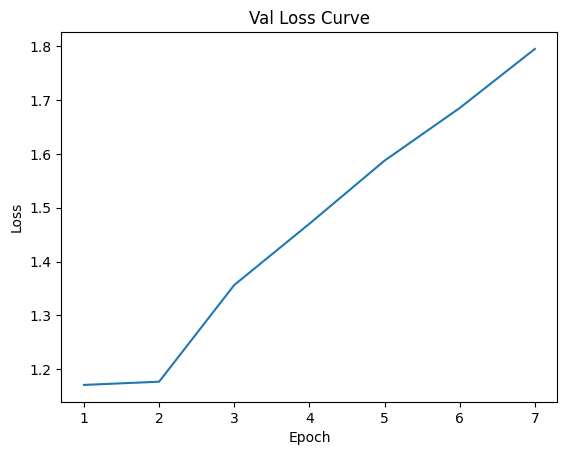

Finished Training Teacher for lambda val of 0
Teacher weights and architecture saved and exported for lambda: 0


In [30]:
# Initialize the dictionary for results
lambda_results = {}

# Loop for training the teacher model with different lambda values
for i in lmda_list_teacher:
    # Reset the teacher model for each lambda
    teacher_model = torchvision.models.efficientnet_b3(weights='DEFAULT')    
    # Replace the last fully connected layer with a new one
    teacher_model.classifier = nn.Linear(1536, num_classes)
    teacher_optimizer = optim.Adam(teacher_model.parameters(), lr=best_lr_teacher)
    
    # Initialize the adversary for the teacher
    adv = Adversary()
    teacher_optimizer_adv = optim.Adam(adv.parameters(), lr=best_lr_teacher)

    # pretrain_teacher(teacher_model, trainloader, criterion_clf, teacher_optimizer, device, epochs_pretrain)
    # pretrain_adversary(adv, student_model, optimizer_adv, trainloader, adv_criterion, device, epochs_pretrain)
    
    # Train the teacher model with adversarial training
    teacher_mean_abs_val_disparity = train_teacher(teacher_model, adv, trainloader, criterion_clf, adv_criterion, teacher_optimizer, teacher_optimizer_adv, device, epochs, i, patience=patience_teacher)

    # Save the teacher model and its state to the 'output_dir'
    teacher_model_weights_path = os.path.join(output_dir, f'teacher_model_weights_ckd_wider_lambda{i}.pth')
    torch.save(teacher_model.state_dict(), teacher_model_weights_path)
    teacher_model_path = os.path.join(output_dir, f'teacher_model_ckd_wider_lambda{i}.pth')
    torch.save(teacher_model, teacher_model_path)
    print('Teacher weights and architecture saved and exported for lambda:', i)

    # Store the teacher results in the dictionary
    lambda_results[i] = {
        'teacher_mean_abs_val_disparity': teacher_mean_abs_val_disparity
    }


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:20<00:00,  2.65it/s]


*****Epoch 1/100*****
*****Train Loss:  0.807007 Val Loss:  0.318456*****
*****Validation Accuracy: 63.12%*****
*****Total Avg Disparity: 0.18067713237768307*****

Class Team_Sports: Recall Difference = 0.09871931087271946
Class Celebration: Recall Difference = -0.00534653465346524
Class Parade: Recall Difference = -0.03125
Class Waiter_Or_Waitress: Recall Difference = 0.08896525391370746
Class Individual_Sports: Recall Difference = -0.18636860174781522
Class Surgeons: Recall Difference = -0.11234294161123426
Class Spa: Recall Difference = -0.7291666666666666
Class Law_Enforcement: Recall Difference = 0.16314553990610314
Class Business: Recall Difference = 0.032683913552645605
Class Dresses: Recall Difference = -0.688622754491018
Class Water_Activities: Recall Difference = 0.02203534170747279
Class Picnic: Recall Difference = -0.18300653594771243
Class Rescue: Recall Difference = 0.07540106951871658
Class Cheering: Recall Difference = 0.05237315875613752
Class Performance_And_Entertain

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:20<00:00,  2.69it/s]


*****Epoch 2/100*****
*****Train Loss:  0.486433 Val Loss:  0.329766*****
*****Validation Accuracy: 63.58%*****
*****Total Avg Disparity: 0.17322437248872166*****

Class Team_Sports: Recall Difference = 0.07512766905439217
Class Celebration: Recall Difference = -0.008564356435643516
Class Parade: Recall Difference = -0.019886363636363646
Class Waiter_Or_Waitress: Recall Difference = 0.08094692630775113
Class Individual_Sports: Recall Difference = -0.2096598002496879
Class Surgeons: Recall Difference = -0.11825572801182549
Class Spa: Recall Difference = -0.6874999999999999
Class Law_Enforcement: Recall Difference = 0.12018779342723007
Class Business: Recall Difference = 0.06717768551048653
Class Dresses: Recall Difference = -0.7305389221556887
Class Water_Activities: Recall Difference = 0.034383649137747496
Class Picnic: Recall Difference = -0.0980392156862745
Class Rescue: Recall Difference = 0.08262032085561499
Class Cheering: Recall Difference = 0.10536006546644838
Class Performance_

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:20<00:00,  2.68it/s]


*****Epoch 3/100*****
*****Train Loss:  0.309215 Val Loss:  0.360361*****
*****Validation Accuracy: 65.22%*****
*****Total Avg Disparity: 0.15531108020704584*****

Class Team_Sports: Recall Difference = 0.08275925100821446
Class Celebration: Recall Difference = -0.010049504950495058
Class Parade: Recall Difference = 0.01041666666666663
Class Waiter_Or_Waitress: Recall Difference = 0.056128293241695215
Class Individual_Sports: Recall Difference = -0.10362047440699118
Class Surgeons: Recall Difference = -0.09312638580931265
Class Spa: Recall Difference = -0.6458333333333334
Class Law_Enforcement: Recall Difference = 0.14389671361502365
Class Business: Recall Difference = 0.04311721494730114
Class Dresses: Recall Difference = -0.6886227544910178
Class Water_Activities: Recall Difference = -0.0005322546306153475
Class Picnic: Recall Difference = -0.36601307189542487
Class Rescue: Recall Difference = -0.03262032085561495
Class Cheering: Recall Difference = -0.051554828150572884
Class Perfor

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:21<00:00,  2.60it/s]


*****Epoch 4/100*****
*****Train Loss:  0.198744 Val Loss:  0.384603*****
*****Validation Accuracy: 65.02%*****
*****Total Avg Disparity: 0.1588622653326633*****

Class Team_Sports: Recall Difference = 0.07772103597582569
Class Celebration: Recall Difference = -0.029455445544554426
Class Parade: Recall Difference = -0.10606060606060608
Class Waiter_Or_Waitress: Recall Difference = 0.10347460862924773
Class Individual_Sports: Recall Difference = -0.11485642946317087
Class Surgeons: Recall Difference = -0.09977827050997767
Class Spa: Recall Difference = -0.5
Class Law_Enforcement: Recall Difference = 0.16643192488262926
Class Business: Recall Difference = 0.02757372511444678
Class Dresses: Recall Difference = -0.6946107784431138
Class Water_Activities: Recall Difference = 0.046625505641899156
Class Picnic: Recall Difference = -0.12418300653594772
Class Rescue: Recall Difference = 0.04652406417112298
Class Cheering: Recall Difference = 0.06137479541734864
Class Performance_And_Entertainme

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:21<00:00,  2.59it/s]


*****Epoch 5/100*****
*****Train Loss:  0.146473 Val Loss:  0.387396*****
*****Validation Accuracy: 65.51%*****
*****Total Avg Disparity: 0.13625357506391866*****

Class Team_Sports: Recall Difference = 0.09353257702985218
Class Celebration: Recall Difference = 0.014752475247524877
Class Parade: Recall Difference = -0.03314393939393934
Class Waiter_Or_Waitress: Recall Difference = -0.0015273004963726189
Class Individual_Sports: Recall Difference = -0.1710362047440699
Class Surgeons: Recall Difference = -0.026607538802660535
Class Spa: Recall Difference = -0.22916666666666663
Class Law_Enforcement: Recall Difference = 0.07863849765258224
Class Business: Recall Difference = 0.054721601192377456
Class Dresses: Recall Difference = -0.7125748502994012
Class Water_Activities: Recall Difference = 0.03502235469448567
Class Picnic: Recall Difference = -0.4444444444444444
Class Rescue: Recall Difference = 0.05748663101604273
Class Cheering: Recall Difference = 0.04766775777414073
Class Performan

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:21<00:00,  2.61it/s]


*****Epoch 6/100*****
*****Train Loss:  0.117513 Val Loss:  0.404821*****
*****Validation Accuracy: 64.73%*****
*****Total Avg Disparity: 0.10800341560837544*****

Class Team_Sports: Recall Difference = 0.09283568107299123
Class Celebration: Recall Difference = 0.009455445544554242
Class Parade: Recall Difference = -0.019886363636363757
Class Waiter_Or_Waitress: Recall Difference = 0.0706376479572356
Class Individual_Sports: Recall Difference = -0.08992665418227208
Class Surgeons: Recall Difference = -0.04582409460458242
Class Spa: Recall Difference = -0.2499999999999999
Class Law_Enforcement: Recall Difference = 0.14976525821596243
Class Business: Recall Difference = 0.019376131161503274
Class Dresses: Recall Difference = -0.4211576846307386
Class Water_Activities: Recall Difference = 0.007025761124121788
Class Picnic: Recall Difference = -0.29411764705882354
Class Rescue: Recall Difference = 0.0034759358288769526
Class Cheering: Recall Difference = -0.018617021276595758
Class Perform

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:20<00:00,  2.66it/s]


*****Epoch 7/100*****
*****Train Loss:  0.098556 Val Loss:  0.373807*****
*****Validation Accuracy: 64.70%*****
*****Total Avg Disparity: 0.14339330159414393*****

Class Team_Sports: Recall Difference = 0.03901474906033309
Class Celebration: Recall Difference = -0.03475247524752467
Class Parade: Recall Difference = -0.030303030303030276
Class Waiter_Or_Waitress: Recall Difference = -0.0076365024818635385
Class Individual_Sports: Recall Difference = -0.15367509363295884
Class Surgeons: Recall Difference = -0.1973392461197338
Class Spa: Recall Difference = -0.1875
Class Law_Enforcement: Recall Difference = 0.11197183098591545
Class Business: Recall Difference = 0.0026615564782284107
Class Dresses: Recall Difference = -0.7305389221556887
Class Water_Activities: Recall Difference = 0.026825633383010472
Class Picnic: Recall Difference = -0.40522875816993464
Class Rescue: Recall Difference = -0.11417112299465243
Class Cheering: Recall Difference = 0.03355155482815059
Class Performance_And_En

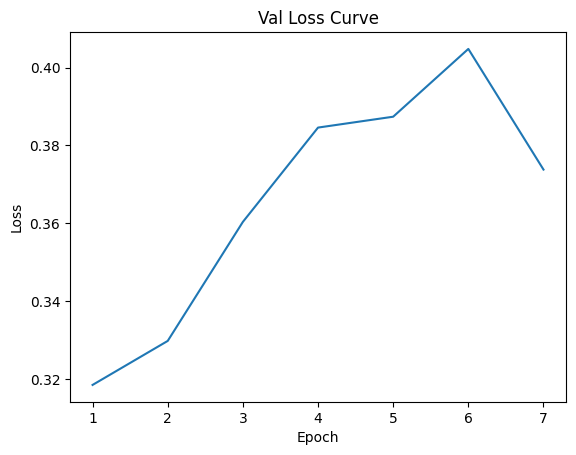

Finished Training Student for lambda value of 0
Student model EfficientNet saved for lambda 0 to Smaller_Student_Models_13/models/EfficientNet_lambda0_20231206_100147.pth
Weights saved for lambda 0 to Smaller_Student_Models_13/weights/EfficientNet_weights_lambda0_20231206_100147.pth


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:20<00:00,  2.65it/s]


*****Epoch 1/100*****
*****Train Loss:  0.819207 Val Loss:  0.313906*****
*****Validation Accuracy: 63.35%*****
*****Total Avg Disparity: 0.1410842697591033*****

Class Team_Sports: Recall Difference = 0.08195953433640657
Class Celebration: Recall Difference = 0.0651485148514851
Class Parade: Recall Difference = 0.048295454545454475
Class Waiter_Or_Waitress: Recall Difference = 0.03130966017563952
Class Individual_Sports: Recall Difference = -0.182896379525593
Class Surgeons: Recall Difference = 0.051736881005173596
Class Spa: Recall Difference = -0.2499999999999999
Class Law_Enforcement: Recall Difference = 0.11314553990610332
Class Business: Recall Difference = 0.03662301714042371
Class Dresses: Recall Difference = -0.5518962075848304
Class Water_Activities: Recall Difference = -0.021077283372365474
Class Picnic: Recall Difference = -0.29411764705882354
Class Rescue: Recall Difference = 0.25106951871657746
Class Cheering: Recall Difference = -0.007774140752864145
Class Performance_An

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:20<00:00,  2.68it/s]


*****Epoch 2/100*****
*****Train Loss:  0.482050 Val Loss:  0.316472*****
*****Validation Accuracy: 64.76%*****
*****Total Avg Disparity: 0.158937839371565*****

Class Team_Sports: Recall Difference = 0.09542904799442486
Class Celebration: Recall Difference = -0.025346534653465258
Class Parade: Recall Difference = -0.01893939393939381
Class Waiter_Or_Waitress: Recall Difference = -0.0076365024818633165
Class Individual_Sports: Recall Difference = -0.1544943820224719
Class Surgeons: Recall Difference = -0.06947524020694762
Class Spa: Recall Difference = -0.5833333333333333
Class Law_Enforcement: Recall Difference = 0.10868544600938956
Class Business: Recall Difference = 0.09432556158841687
Class Dresses: Recall Difference = -0.682634730538922
Class Water_Activities: Recall Difference = -0.0005322546306153475
Class Picnic: Recall Difference = -0.29411764705882354
Class Rescue: Recall Difference = 0.18368983957219254
Class Cheering: Recall Difference = -0.0059328968903437085
Class Perform

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:20<00:00,  2.65it/s]


*****Epoch 3/100*****
*****Train Loss:  0.303859 Val Loss:  0.352522*****
*****Validation Accuracy: 65.14%*****
*****Total Avg Disparity: 0.1430153330404341*****

Class Team_Sports: Recall Difference = 0.12091716077732462
Class Celebration: Recall Difference = 0.020148514851485166
Class Parade: Recall Difference = 0.04640151515151514
Class Waiter_Or_Waitress: Recall Difference = 0.056128293241695215
Class Individual_Sports: Recall Difference = -0.1745084269662921
Class Surgeons: Recall Difference = -0.12416851441241661
Class Spa: Recall Difference = -0.14583333333333337
Class Law_Enforcement: Recall Difference = 0.1279342723004696
Class Business: Recall Difference = 0.050463110827211666
Class Dresses: Recall Difference = -0.5459081836327345
Class Water_Activities: Recall Difference = -0.008728975942090877
Class Picnic: Recall Difference = -0.40522875816993464
Class Rescue: Recall Difference = 0.07941176470588235
Class Cheering: Recall Difference = -0.08592471358428805
Class Performance

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:20<00:00,  2.66it/s]


*****Epoch 4/100*****
*****Train Loss:  0.185697 Val Loss:  0.381363*****
*****Validation Accuracy: 65.22%*****
*****Total Avg Disparity: 0.1274212690332345*****

Class Team_Sports: Recall Difference = 0.08779746604060279
Class Celebration: Recall Difference = 0.054257425742574306
Class Parade: Recall Difference = 0.04640151515151514
Class Waiter_Or_Waitress: Recall Difference = 0.04581901489117968
Class Individual_Sports: Recall Difference = -0.13467540574282144
Class Surgeons: Recall Difference = -0.12416851441241672
Class Spa: Recall Difference = -0.02083333333333326
Class Law_Enforcement: Recall Difference = 0.11314553990610321
Class Business: Recall Difference = 0.05642499733844353
Class Dresses: Recall Difference = -0.5758483033932135
Class Water_Activities: Recall Difference = 0.041835213966361584
Class Picnic: Recall Difference = -0.326797385620915
Class Rescue: Recall Difference = 0.04732620320855613
Class Cheering: Recall Difference = 0.018821603927986874
Class Performance_An

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:20<00:00,  2.72it/s]


*****Epoch 5/100*****
*****Train Loss:  0.128259 Val Loss:  0.372601*****
*****Validation Accuracy: 65.71%*****
*****Total Avg Disparity: 0.14988100550167477*****

Class Team_Sports: Recall Difference = 0.12131701911322845
Class Celebration: Recall Difference = -0.04514851485148519
Class Parade: Recall Difference = -0.0028409090909091717
Class Waiter_Or_Waitress: Recall Difference = 0.03130966017563952
Class Individual_Sports: Recall Difference = -0.1804385143570536
Class Surgeons: Recall Difference = -0.008130081300812941
Class Spa: Recall Difference = -0.6458333333333333
Class Law_Enforcement: Recall Difference = 0.12089201877934275
Class Business: Recall Difference = 0.03406792292132432
Class Dresses: Recall Difference = -0.4920159680638724
Class Water_Activities: Recall Difference = 0.06301894826485
Class Picnic: Recall Difference = -0.29411764705882354
Class Rescue: Recall Difference = 0.1532085561497326
Class Cheering: Recall Difference = 0.020867430441898482
Class Performance_An

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:20<00:00,  2.66it/s]


*****Epoch 6/100*****
*****Train Loss:  0.099260 Val Loss:  0.362384*****
*****Validation Accuracy: 65.31%*****
*****Total Avg Disparity: 0.1619225274417047*****

Class Team_Sports: Recall Difference = 0.08615233460145544
Class Celebration: Recall Difference = -0.07485148514851492
Class Parade: Recall Difference = -0.07575757575757569
Class Waiter_Or_Waitress: Recall Difference = -0.04887361588392525
Class Individual_Sports: Recall Difference = -0.1622581148564295
Class Surgeons: Recall Difference = -0.05099778270509958
Class Spa: Recall Difference = -0.7083333333333333
Class Law_Enforcement: Recall Difference = 0.13943661971830978
Class Business: Recall Difference = 0.055573299265410436
Class Dresses: Recall Difference = -0.40319361277445104
Class Water_Activities: Recall Difference = 0.03502235469448567
Class Picnic: Recall Difference = -0.36601307189542487
Class Rescue: Recall Difference = 0.1053475935828877
Class Cheering: Recall Difference = 0.03600654664484437
Class Performance_A

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:20<00:00,  2.67it/s]


*****Epoch 7/100*****
*****Train Loss:  0.085043 Val Loss:  0.368394*****
*****Validation Accuracy: 65.37%*****
*****Total Avg Disparity: 0.16287776822470185*****

Class Team_Sports: Recall Difference = 0.04594943505729421
Class Celebration: Recall Difference = -0.025643564356435555
Class Parade: Recall Difference = -0.048295454545454586
Class Waiter_Or_Waitress: Recall Difference = 0.029400534555173663
Class Individual_Sports: Recall Difference = -0.13467540574282144
Class Surgeons: Recall Difference = -0.17886178861788615
Class Spa: Recall Difference = -0.6249999999999999
Class Law_Enforcement: Recall Difference = 0.02089201877934277
Class Business: Recall Difference = 0.049611412754178685
Class Dresses: Recall Difference = -0.48003992015968067
Class Water_Activities: Recall Difference = 0.012454758356397866
Class Picnic: Recall Difference = -0.4379084967320261
Class Rescue: Recall Difference = 0.2096256684491979
Class Cheering: Recall Difference = -0.06976268412438635
Class Performa

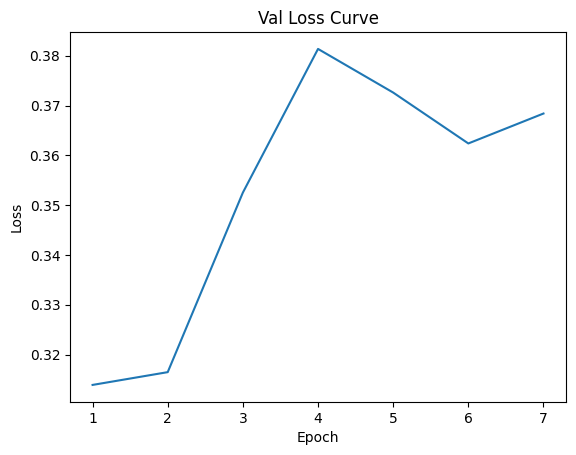

Finished Training Student for lambda value of 0
Student model EfficientNet saved for lambda 0 to Smaller_Student_Models_13/models/EfficientNet_lambda0_20231206_101653.pth
Weights saved for lambda 0 to Smaller_Student_Models_13/weights/EfficientNet_weights_lambda0_20231206_101653.pth


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:19<00:00,  2.76it/s]


*****Epoch 1/100*****
*****Train Loss:  0.817753 Val Loss:  0.335607*****
*****Validation Accuracy: 60.32%*****
*****Total Avg Disparity: 0.16911185686666758*****

Class Team_Sports: Recall Difference = 0.10451154448138367
Class Celebration: Recall Difference = -0.01856435643564358
Class Parade: Recall Difference = 0.04640151515151514
Class Waiter_Or_Waitress: Recall Difference = -0.10423825887743421
Class Individual_Sports: Recall Difference = -0.19900905118601742
Class Surgeons: Recall Difference = -0.16038433111603845
Class Spa: Recall Difference = -0.6250000000000001
Class Law_Enforcement: Recall Difference = 0.14647887323943687
Class Business: Recall Difference = 0.06377089321835405
Class Dresses: Recall Difference = -0.4620758483033931
Class Water_Activities: Recall Difference = -0.020332126889504032
Class Picnic: Recall Difference = -0.25490196078431376
Class Rescue: Recall Difference = -0.0641711229946524
Class Cheering: Recall Difference = 0.0032733224222585844
Class Performan

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:19<00:00,  2.77it/s]


*****Epoch 2/100*****
*****Train Loss:  0.501888 Val Loss:  0.327639*****
*****Validation Accuracy: 63.61%*****
*****Total Avg Disparity: 0.11426621240795294*****

Class Team_Sports: Recall Difference = 0.14271515234602605
Class Celebration: Recall Difference = 0.04554455445544553
Class Parade: Recall Difference = 0.029356060606060552
Class Waiter_Or_Waitress: Recall Difference = -0.028255059182894282
Class Individual_Sports: Recall Difference = -0.16143882646691643
Class Surgeons: Recall Difference = 0.057649667405765104
Class Spa: Recall Difference = -0.1874999999999999
Class Law_Enforcement: Recall Difference = 0.11126760563380267
Class Business: Recall Difference = -0.02757372511444689
Class Dresses: Recall Difference = -0.08782435129740529
Class Water_Activities: Recall Difference = 0.04524164360229932
Class Picnic: Recall Difference = -0.18300653594771243
Class Rescue: Recall Difference = 0.138235294117647
Class Cheering: Recall Difference = -0.09144844517184941
Class Performance

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:20<00:00,  2.70it/s]


*****Epoch 3/100*****
*****Train Loss:  0.343429 Val Loss:  0.361170*****
*****Validation Accuracy: 64.36%*****
*****Total Avg Disparity: 0.135013674698854*****

Class Team_Sports: Recall Difference = 0.05796803418217544
Class Celebration: Recall Difference = 0.015049504950495174
Class Parade: Recall Difference = 0.06628787878787878
Class Waiter_Or_Waitress: Recall Difference = 0.002672775868652
Class Individual_Sports: Recall Difference = -0.16592540574282144
Class Surgeons: Recall Difference = -0.11751662971175159
Class Spa: Recall Difference = -0.20833333333333326
Class Law_Enforcement: Recall Difference = 0.09530516431924885
Class Business: Recall Difference = 0.019376131161503274
Class Dresses: Recall Difference = -0.42714570858283435
Class Water_Activities: Recall Difference = 0.02884820097934848
Class Picnic: Recall Difference = -0.36601307189542487
Class Rescue: Recall Difference = 0.17272727272727276
Class Cheering: Recall Difference = -0.05748772504091654
Class Performance_An

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:20<00:00,  2.70it/s]


*****Epoch 4/100*****
*****Train Loss:  0.235193 Val Loss:  0.396349*****
*****Validation Accuracy: 63.69%*****
*****Total Avg Disparity: 0.10120593914578907*****

Class Team_Sports: Recall Difference = 0.08520409911916926
Class Celebration: Recall Difference = 0.04975247524752474
Class Parade: Recall Difference = 0.019886363636363535
Class Waiter_Or_Waitress: Recall Difference = -0.09201985490645281
Class Individual_Sports: Recall Difference = -0.15632802746566787
Class Surgeons: Recall Difference = -0.02734663710273466
Class Spa: Recall Difference = -0.1250000000000001
Class Law_Enforcement: Recall Difference = 0.13239436619718326
Class Business: Recall Difference = -0.0717555626530395
Class Dresses: Recall Difference = -0.2544910179640719
Class Water_Activities: Recall Difference = 0.005641899084522062
Class Picnic: Recall Difference = -0.23529411764705882
Class Rescue: Recall Difference = 0.10775401069518714
Class Cheering: Recall Difference = -0.025163666121112926
Class Performanc

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:20<00:00,  2.74it/s]


*****Epoch 5/100*****
*****Train Loss:  0.172294 Val Loss:  0.381344*****
*****Validation Accuracy: 65.45%*****
*****Total Avg Disparity: 0.13531340610786863*****

Class Team_Sports: Recall Difference = 0.10181535684500354
Class Celebration: Recall Difference = 0.03524752475247522
Class Parade: Recall Difference = 0.02840909090909094
Class Waiter_Or_Waitress: Recall Difference = 0.07674684994272618
Class Individual_Sports: Recall Difference = -0.11649500624219733
Class Surgeons: Recall Difference = -0.09977827050997778
Class Spa: Recall Difference = -0.14583333333333337
Class Law_Enforcement: Recall Difference = 0.167605633802817
Class Business: Recall Difference = 0.028957734483125774
Class Dresses: Recall Difference = -0.4331337325349302
Class Water_Activities: Recall Difference = 0.03704492229082401
Class Picnic: Recall Difference = -0.3333333333333333
Class Rescue: Recall Difference = 0.118716577540107
Class Cheering: Recall Difference = -0.12295417348608839
Class Performance_And_E

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:20<00:00,  2.70it/s]


*****Epoch 6/100*****
*****Train Loss:  0.133650 Val Loss:  0.395871*****
*****Validation Accuracy: 64.44%*****
*****Total Avg Disparity: 0.1567984365022232*****

Class Team_Sports: Recall Difference = 0.07622442334715707
Class Celebration: Recall Difference = 0.01975247524752466
Class Parade: Recall Difference = -0.017045454545454697
Class Waiter_Or_Waitress: Recall Difference = 0.029400534555173663
Class Individual_Sports: Recall Difference = -0.13120318352059934
Class Surgeons: Recall Difference = -0.002956393200295726
Class Spa: Recall Difference = -0.5625
Class Law_Enforcement: Recall Difference = 0.10422535211267614
Class Business: Recall Difference = -0.0038326413286490224
Class Dresses: Recall Difference = -0.5518962075848304
Class Water_Activities: Recall Difference = 0.021396636150734616
Class Picnic: Recall Difference = -0.40522875816993464
Class Rescue: Recall Difference = 0.17352941176470588
Class Cheering: Recall Difference = -0.07733224222585933
Class Performance_And_Ent

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:20<00:00,  2.74it/s]


*****Epoch 7/100*****
*****Train Loss:  0.113018 Val Loss:  0.390584*****
*****Validation Accuracy: 64.01%*****
*****Total Avg Disparity: 0.14788611874220442*****

Class Team_Sports: Recall Difference = 0.06924403925466416
Class Celebration: Recall Difference = 0.07905940594059402
Class Parade: Recall Difference = 0.027462121212121327
Class Waiter_Or_Waitress: Recall Difference = 0.04390988927071393
Class Individual_Sports: Recall Difference = -0.12507802746566798
Class Surgeons: Recall Difference = 0.05173688100517371
Class Spa: Recall Difference = -0.6041666666666666
Class Law_Enforcement: Recall Difference = 0.12863849765258228
Class Business: Recall Difference = 0.003513254551261502
Class Dresses: Recall Difference = -0.39121756487025966
Class Water_Activities: Recall Difference = 0.023419203747072626
Class Picnic: Recall Difference = -0.215686274509804
Class Rescue: Recall Difference = 0.14224598930481291
Class Cheering: Recall Difference = -0.05155482815057283
Class Performance_A

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:20<00:00,  2.67it/s]


*****Epoch 8/100*****
*****Train Loss:  0.104601 Val Loss:  0.385816*****
*****Validation Accuracy: 65.80%*****
*****Total Avg Disparity: 0.14339264587243034*****

Class Team_Sports: Recall Difference = 0.10729912830882782
Class Celebration: Recall Difference = -0.08445544554455447
Class Parade: Recall Difference = 0.06818181818181823
Class Waiter_Or_Waitress: Recall Difference = -0.04887361588392525
Class Individual_Sports: Recall Difference = -0.1692025593008739
Class Surgeons: Recall Difference = 0.03399852180340002
Class Spa: Recall Difference = -0.10416666666666652
Class Law_Enforcement: Recall Difference = 0.047183098591549344
Class Business: Recall Difference = -0.04769509208985423
Class Dresses: Recall Difference = -0.4690618762475051
Class Water_Activities: Recall Difference = -0.0203321268895037
Class Picnic: Recall Difference = -0.5163398692810457
Class Rescue: Recall Difference = 0.17673796791443858
Class Cheering: Recall Difference = -0.07324058919803605
Class Performance_

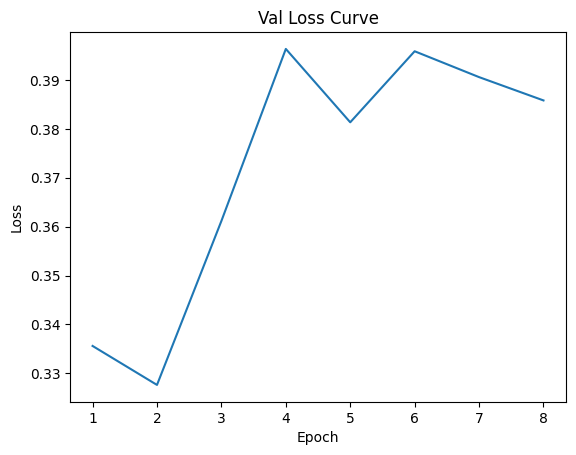

Finished Training Student for lambda value of 0
Student model EfficientNet saved for lambda 0 to Smaller_Student_Models_13/models/EfficientNet_lambda0_20231206_103122.pth
Weights saved for lambda 0 to Smaller_Student_Models_13/weights/EfficientNet_weights_lambda0_20231206_103122.pth


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:20<00:00,  2.73it/s]


*****Epoch 1/100*****
*****Train Loss:  0.816340 Val Loss:  0.410334*****
*****Validation Accuracy: 54.43%*****
*****Total Avg Disparity: 0.1401540343412306*****

Class Team_Sports: Recall Difference = 0.07687562120848612
Class Celebration: Recall Difference = 0.0921287128712871
Class Parade: Recall Difference = 0.007575757575757458
Class Waiter_Or_Waitress: Recall Difference = -0.11263841160748378
Class Individual_Sports: Recall Difference = -0.147159800249688
Class Surgeons: Recall Difference = -0.07095343680709532
Class Spa: Recall Difference = -0.35416666666666663
Class Law_Enforcement: Recall Difference = 0.1619718309859154
Class Business: Recall Difference = 0.04737570531246671
Class Dresses: Recall Difference = -0.4810379241516966
Class Water_Activities: Recall Difference = 0.1348733233979137
Class Picnic: Recall Difference = -0.18300653594771243
Class Rescue: Recall Difference = -0.041443850267379664
Class Cheering: Recall Difference = 0.04193944353518822
Class Performance_And_

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:19<00:00,  2.77it/s]


*****Epoch 2/100*****
*****Train Loss:  0.603690 Val Loss:  0.396412*****
*****Validation Accuracy: 58.07%*****
*****Total Avg Disparity: 0.12622095382014334*****

Class Team_Sports: Recall Difference = 0.1217168774491324
Class Celebration: Recall Difference = 0.10004950495049503
Class Parade: Recall Difference = 0.05397727272727271
Class Waiter_Or_Waitress: Recall Difference = -0.08591065292096234
Class Individual_Sports: Recall Difference = -0.22518726591760302
Class Surgeons: Recall Difference = 0.0509977827050998
Class Spa: Recall Difference = -0.02083333333333337
Class Law_Enforcement: Recall Difference = -0.032863849765258135
Class Business: Recall Difference = 0.03183221547961246
Class Dresses: Recall Difference = -0.4620758483033932
Class Water_Activities: Recall Difference = 0.03374494358100921
Class Picnic: Recall Difference = -0.3790849673202614
Class Rescue: Recall Difference = 0.06684491978609627
Class Cheering: Recall Difference = 0.058306055646481114
Class Performance_An

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:20<00:00,  2.72it/s]


*****Epoch 3/100*****
*****Train Loss:  0.464223 Val Loss:  0.416772*****
*****Validation Accuracy: 58.44%*****
*****Total Avg Disparity: 0.12771710200879058*****

Class Team_Sports: Recall Difference = 0.07403091476162726
Class Celebration: Recall Difference = 0.0050495049504951095
Class Parade: Recall Difference = 0.012310606060606188
Class Waiter_Or_Waitress: Recall Difference = -0.21305841924398633
Class Individual_Sports: Recall Difference = -0.16736891385767794
Class Surgeons: Recall Difference = 0.057649667405765104
Class Spa: Recall Difference = -0.0625
Class Law_Enforcement: Recall Difference = 0.09859154929577474
Class Business: Recall Difference = -0.07143617587565204
Class Dresses: Recall Difference = -0.7125748502994013
Class Water_Activities: Recall Difference = 0.09793485203321273
Class Picnic: Recall Difference = -0.1045751633986928
Class Rescue: Recall Difference = 0.015240641711229963
Class Cheering: Recall Difference = -0.031096563011456607
Class Performance_And_Ente

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:20<00:00,  2.74it/s]


*****Epoch 4/100*****
*****Train Loss:  0.343913 Val Loss:  0.483563*****
*****Validation Accuracy: 55.32%*****
*****Total Avg Disparity: 0.1439522288253528*****

Class Team_Sports: Recall Difference = 0.07313980189875602
Class Celebration: Recall Difference = 0.11544554455445544
Class Parade: Recall Difference = -0.0028409090909089496
Class Waiter_Or_Waitress: Recall Difference = -0.17640320733104253
Class Individual_Sports: Recall Difference = -0.10303526841448196
Class Surgeons: Recall Difference = -0.04582409460458242
Class Spa: Recall Difference = -0.5833333333333333
Class Law_Enforcement: Recall Difference = 0.02746478873239433
Class Business: Recall Difference = 0.018205046311082884
Class Dresses: Recall Difference = -0.5808383233532934
Class Water_Activities: Recall Difference = 0.0685543964232489
Class Picnic: Recall Difference = -0.2222222222222222
Class Rescue: Recall Difference = 0.0542780748663102
Class Cheering: Recall Difference = 0.011865793780687361
Class Performance_A

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:19<00:00,  2.76it/s]


*****Epoch 5/100*****
*****Train Loss:  0.256321 Val Loss:  0.484660*****
*****Validation Accuracy: 56.54%*****
*****Total Avg Disparity: 0.1207713440078793*****

Class Team_Sports: Recall Difference = 0.05752247775073982
Class Celebration: Recall Difference = -0.023366336633663387
Class Parade: Recall Difference = -0.08143939393939392
Class Waiter_Or_Waitress: Recall Difference = -0.001145475372279603
Class Individual_Sports: Recall Difference = -0.07892478152309612
Class Surgeons: Recall Difference = -0.05173688100517371
Class Spa: Recall Difference = 0.25
Class Law_Enforcement: Recall Difference = 0.09342723004694853
Class Business: Recall Difference = -0.027041413818801208
Class Dresses: Recall Difference = -0.47305389221556887
Class Water_Activities: Recall Difference = 0.09388971684053649
Class Picnic: Recall Difference = -0.14379084967320266
Class Rescue: Recall Difference = 0.10213903743315506
Class Cheering: Recall Difference = -0.028641571194762683
Class Performance_And_Enter

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:19<00:00,  2.75it/s]


*****Epoch 6/100*****
*****Train Loss:  0.183507 Val Loss:  0.461131*****
*****Validation Accuracy: 57.37%*****
*****Total Avg Disparity: 0.13219775752926086*****

Class Team_Sports: Recall Difference = 0.07263712284790536
Class Celebration: Recall Difference = 0.025544554455445567
Class Parade: Recall Difference = 0.03882575757575768
Class Waiter_Or_Waitress: Recall Difference = -0.06720122184039712
Class Individual_Sports: Recall Difference = -0.09098002496878899
Class Surgeons: Recall Difference = -0.045824094604582366
Class Spa: Recall Difference = 0.5
Class Law_Enforcement: Recall Difference = 0.12417840375586853
Class Business: Recall Difference = -0.02363462152666873
Class Dresses: Recall Difference = -0.5389221556886228
Class Water_Activities: Recall Difference = 0.02001277411113489
Class Picnic: Recall Difference = -0.1895424836601307
Class Rescue: Recall Difference = 0.01978609625668451
Class Cheering: Recall Difference = -0.06608019639934537
Class Performance_And_Entertainme

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:20<00:00,  2.75it/s]


*****Epoch 7/100*****
*****Train Loss:  0.131717 Val Loss:  0.430679*****
*****Validation Accuracy: 58.73%*****
*****Total Avg Disparity: 0.1628775193460252*****

Class Team_Sports: Recall Difference = 0.08181101552592807
Class Celebration: Recall Difference = 0.04074257425742572
Class Parade: Recall Difference = 0.029356060606060552
Class Waiter_Or_Waitress: Recall Difference = -0.054982817869415945
Class Individual_Sports: Recall Difference = -0.11774344569288397
Class Surgeons: Recall Difference = -0.033998521803399795
Class Spa: Recall Difference = -0.4375
Class Law_Enforcement: Recall Difference = 0.08380281690140845
Class Business: Recall Difference = -0.06409027999574146
Class Dresses: Recall Difference = -0.6826347305389222
Class Water_Activities: Recall Difference = 0.04396423248882275
Class Picnic: Recall Difference = -0.3790849673202615
Class Rescue: Recall Difference = 0.21657754010695185
Class Cheering: Recall Difference = 0.057896890343698826
Class Performance_And_Enterta

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:19<00:00,  2.75it/s]


*****Epoch 8/100*****
*****Train Loss:  0.105923 Val Loss:  0.406911*****
*****Validation Accuracy: 59.97%*****
*****Total Avg Disparity: 0.1292793826867123*****

Class Team_Sports: Recall Difference = 0.09268716226251272
Class Celebration: Recall Difference = 0.05024752475247529
Class Parade: Recall Difference = -0.05397727272727271
Class Waiter_Or_Waitress: Recall Difference = -0.03856433753340982
Class Individual_Sports: Recall Difference = -0.15246566791510618
Class Surgeons: Recall Difference = 0.028085735402808565
Class Spa: Recall Difference = -0.0625
Class Law_Enforcement: Recall Difference = 0.11384976525821588
Class Business: Recall Difference = 0.019376131161503274
Class Dresses: Recall Difference = -0.7425149700598802
Class Water_Activities: Recall Difference = -0.03938684266553116
Class Picnic: Recall Difference = -0.3333333333333333
Class Rescue: Recall Difference = 0.02058823529411763
Class Cheering: Recall Difference = 0.0503273322422258
Class Performance_And_Entertainm

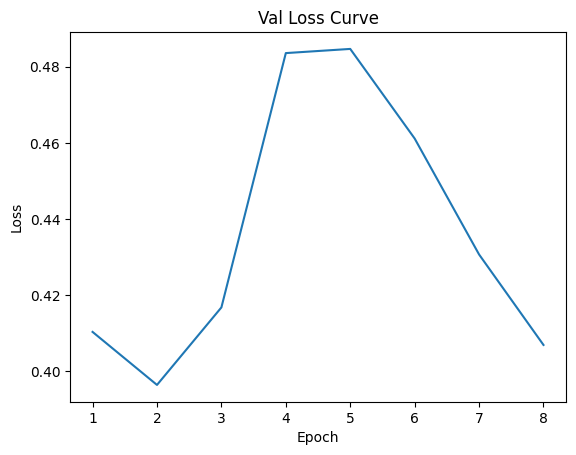

Finished Training Student for lambda value of 0
Student model MobileNetV2 saved for lambda 0 to Smaller_Student_Models_13/models/MobileNetV2_lambda0_20231206_104500.pth
Weights saved for lambda 0 to Smaller_Student_Models_13/weights/MobileNetV2_weights_lambda0_20231206_104500.pth


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:19<00:00,  2.79it/s]


*****Epoch 1/100*****
*****Train Loss:  1.110944 Val Loss:  0.571604*****
*****Validation Accuracy: 40.66%*****
*****Total Avg Disparity: 0.11097844062466566*****

Class Team_Sports: Recall Difference = 0.12101998149227122
Class Celebration: Recall Difference = -0.09425742574257417
Class Parade: Recall Difference = -0.03409090909090906
Class Waiter_Or_Waitress: Recall Difference = 0.0
Class Individual_Sports: Recall Difference = -0.19229868913857684
Class Surgeons: Recall Difference = 0.0
Class Spa: Recall Difference = 0.0
Class Law_Enforcement: Recall Difference = 0.15892018779342726
Class Business: Recall Difference = 0.0
Class Dresses: Recall Difference = 0.19560878243512972
Class Water_Activities: Recall Difference = 0.005003193527783778
Class Picnic: Recall Difference = 0.0
Class Rescue: Recall Difference = 0.0
Class Cheering: Recall Difference = 0.0
Class Performance_And_Entertainment: Recall Difference = 0.08662835577665329
Class Family: Recall Difference = 0.0
Data has been app

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:19<00:00,  2.83it/s]


*****Epoch 2/100*****
*****Train Loss:  0.829650 Val Loss:  0.468274*****
*****Validation Accuracy: 49.90%*****
*****Total Avg Disparity: 0.11655325264800373*****

Class Team_Sports: Recall Difference = 0.12485862151694826
Class Celebration: Recall Difference = 0.05123762376237623
Class Parade: Recall Difference = 0.07765151515151514
Class Waiter_Or_Waitress: Recall Difference = -0.1240931653302787
Class Individual_Sports: Recall Difference = -0.21211766541822719
Class Surgeons: Recall Difference = 0.0
Class Spa: Recall Difference = 0.0
Class Law_Enforcement: Recall Difference = 0.24201877934272292
Class Business: Recall Difference = -0.015117640796337706
Class Dresses: Recall Difference = -0.4740518962075849
Class Water_Activities: Recall Difference = -0.007983819459229324
Class Picnic: Recall Difference = -0.0196078431372549
Class Rescue: Recall Difference = 0.023529411764705882
Class Cheering: Recall Difference = 0.007569558101472997
Class Performance_And_Entertainment: Recall Diffe

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:19<00:00,  2.87it/s]


*****Epoch 3/100*****
*****Train Loss:  0.658382 Val Loss:  0.427665*****
*****Validation Accuracy: 54.49%*****
*****Total Avg Disparity: 0.13370338880166138*****

Class Team_Sports: Recall Difference = 0.10875004284196466
Class Celebration: Recall Difference = 0.021435643564356455
Class Parade: Recall Difference = 0.03598484848484862
Class Waiter_Or_Waitress: Recall Difference = -0.10003818251240937
Class Individual_Sports: Recall Difference = -0.1285502496878902
Class Surgeons: Recall Difference = 0.0
Class Spa: Recall Difference = 0.0
Class Law_Enforcement: Recall Difference = 0.27347417840375593
Class Business: Recall Difference = 0.007771744916427181
Class Dresses: Recall Difference = -0.7245508982035929
Class Water_Activities: Recall Difference = 0.03981264637002346
Class Picnic: Recall Difference = 0.10457516339869283
Class Rescue: Recall Difference = -0.031283422459893045
Class Cheering: Recall Difference = 0.08592471358428805
Class Performance_And_Entertainment: Recall Differe

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:19<00:00,  2.82it/s]


*****Epoch 4/100*****
*****Train Loss:  0.525870 Val Loss:  0.443554*****
*****Validation Accuracy: 53.85%*****
*****Total Avg Disparity: 0.11895165450887002*****

Class Team_Sports: Recall Difference = 0.16611257725834283
Class Celebration: Recall Difference = 0.006534653465346485
Class Parade: Recall Difference = 0.02083333333333337
Class Waiter_Or_Waitress: Recall Difference = -0.05880106911034744
Class Individual_Sports: Recall Difference = -0.153480024968789
Class Surgeons: Recall Difference = -0.05395417590539543
Class Spa: Recall Difference = -0.16666666666666666
Class Law_Enforcement: Recall Difference = 0.21713615023474192
Class Business: Recall Difference = -0.040029809432556185
Class Dresses: Recall Difference = -0.7065868263473054
Class Water_Activities: Recall Difference = 0.05279965935703623
Class Picnic: Recall Difference = 0.03267973856209144
Class Rescue: Recall Difference = 0.014171122994652396
Class Cheering: Recall Difference = 0.04132569558101476
Class Performance_

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:19<00:00,  2.83it/s]


*****Epoch 5/100*****
*****Train Loss:  0.405803 Val Loss:  0.450442*****
*****Validation Accuracy: 55.47%*****
*****Total Avg Disparity: 0.1218918055532279*****

Class Team_Sports: Recall Difference = 0.07687562120848623
Class Celebration: Recall Difference = 0.01603960396039611
Class Parade: Recall Difference = 0.04450757575757591
Class Waiter_Or_Waitress: Recall Difference = 0.04810996563573877
Class Individual_Sports: Recall Difference = -0.2017009987515606
Class Surgeons: Recall Difference = 0.0805617147080562
Class Spa: Recall Difference = 0.0625
Class Law_Enforcement: Recall Difference = 0.22347417840375583
Class Business: Recall Difference = 0.028425423187480092
Class Dresses: Recall Difference = -0.6706586826347304
Class Water_Activities: Recall Difference = 0.08430913348946156
Class Picnic: Recall Difference = -0.05228758169934633
Class Rescue: Recall Difference = 0.13422459893048125
Class Cheering: Recall Difference = 0.05135024549918166
Class Performance_And_Entertainment: 

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:19<00:00,  2.81it/s]


*****Epoch 6/100*****
*****Train Loss:  0.310120 Val Loss:  0.504670*****
*****Validation Accuracy: 53.85%*****
*****Total Avg Disparity: 0.16038745423852108*****

Class Team_Sports: Recall Difference = 0.08566108007448792
Class Celebration: Recall Difference = 0.03613861386138617
Class Parade: Recall Difference = -0.061553030303030276
Class Waiter_Or_Waitress: Recall Difference = 0.02138220694921711
Class Individual_Sports: Recall Difference = -0.17329900124843944
Class Surgeons: Recall Difference = 0.18403547671840356
Class Spa: Recall Difference = -0.4791666666666667
Class Law_Enforcement: Recall Difference = 0.20492957746478863
Class Business: Recall Difference = 0.0024486319599701933
Class Dresses: Recall Difference = -0.7125748502994013
Class Water_Activities: Recall Difference = 0.00777091760698323
Class Picnic: Recall Difference = -0.19607843137254916
Class Rescue: Recall Difference = 0.12486631016042782
Class Cheering: Recall Difference = 0.02598199672667756
Class Performance_

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:19<00:00,  2.79it/s]


*****Epoch 7/100*****
*****Train Loss:  0.238239 Val Loss:  0.479286*****
*****Validation Accuracy: 54.55%*****
*****Total Avg Disparity: 0.1225913566337096*****

Class Team_Sports: Recall Difference = 0.05857353394797271
Class Celebration: Recall Difference = 0.07524752475247526
Class Parade: Recall Difference = 0.05871212121212116
Class Waiter_Or_Waitress: Recall Difference = -0.08972890416189383
Class Individual_Sports: Recall Difference = -0.1432584269662921
Class Surgeons: Recall Difference = 0.1182557280118256
Class Spa: Recall Difference = 0.0625
Class Law_Enforcement: Recall Difference = 0.08450704225352113
Class Business: Recall Difference = -0.05078249760459913
Class Dresses: Recall Difference = -0.7125748502994013
Class Water_Activities: Recall Difference = 0.01596763891845865
Class Picnic: Recall Difference = -0.18954248366013077
Class Rescue: Recall Difference = -0.026470588235294135
Class Cheering: Recall Difference = 0.011865793780687417
Class Performance_And_Entertainme

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:19<00:00,  2.85it/s]


*****Epoch 8/100*****
*****Train Loss:  0.185429 Val Loss:  0.485497*****
*****Validation Accuracy: 55.01%*****
*****Total Avg Disparity: 0.1089999771489012*****

Class Team_Sports: Recall Difference = 0.11498783288206471
Class Celebration: Recall Difference = -0.019554455445544572
Class Parade: Recall Difference = -0.05681818181818199
Class Waiter_Or_Waitress: Recall Difference = -0.08361970217640324
Class Individual_Sports: Recall Difference = -0.210479088639201
Class Surgeons: Recall Difference = 0.08795269770879538
Class Spa: Recall Difference = -0.12499999999999989
Class Law_Enforcement: Recall Difference = 0.1338028169014085
Class Business: Recall Difference = -0.04258490365165546
Class Dresses: Recall Difference = -0.5329341317365269
Class Water_Activities: Recall Difference = 0.01799020651479688
Class Picnic: Recall Difference = -0.12418300653594772
Class Rescue: Recall Difference = -0.002941176470588225
Class Cheering: Recall Difference = 0.040711947626841216
Class Performance

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:19<00:00,  2.82it/s]


*****Epoch 9/100*****
*****Train Loss:  0.142872 Val Loss:  0.505472*****
*****Validation Accuracy: 54.31%*****
*****Total Avg Disparity: 0.10344267566977178*****

Class Team_Sports: Recall Difference = 0.0857067781700197
Class Celebration: Recall Difference = -0.08866336633663363
Class Parade: Recall Difference = 0.04166666666666663
Class Waiter_Or_Waitress: Recall Difference = -0.028255059182894282
Class Individual_Sports: Recall Difference = -0.20088171036204744
Class Surgeons: Recall Difference = 0.09386548410938655
Class Spa: Recall Difference = -0.02083333333333337
Class Law_Enforcement: Recall Difference = 0.03661971830985916
Class Business: Recall Difference = -0.06068348770360904
Class Dresses: Recall Difference = -0.5329341317365269
Class Water_Activities: Recall Difference = 0.029593357462209924
Class Picnic: Recall Difference = -0.0326797385620915
Class Rescue: Recall Difference = 0.10534759358288776
Class Cheering: Recall Difference = 0.004296235679214444
Class Performance

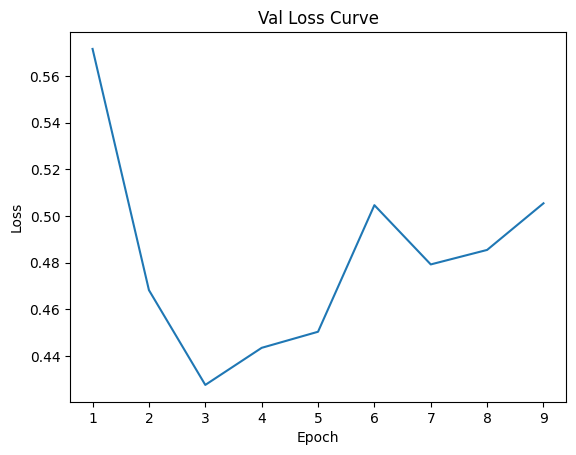

Finished Training Student for lambda value of 0
Student model ShuffleNetV2 saved for lambda 0 to Smaller_Student_Models_13/models/ShuffleNetV2_lambda0_20231206_105703.pth
Weights saved for lambda 0 to Smaller_Student_Models_13/weights/ShuffleNetV2_weights_lambda0_20231206_105703.pth


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:19<00:00,  2.77it/s]


*****Epoch 1/100*****
*****Train Loss:  1.163084 Val Loss:  0.763809*****
*****Validation Accuracy: 27.68%*****
*****Total Avg Disparity: 0.040056394860771234*****

Class Team_Sports: Recall Difference = 0.012475580080200221
Class Celebration: Recall Difference = -0.015198019801980198
Class Parade: Recall Difference = -0.03125
Class Waiter_Or_Waitress: Recall Difference = -0.014509354715540296
Class Individual_Sports: Recall Difference = 0.09667602996254679
Class Surgeons: Recall Difference = 0.0
Class Spa: Recall Difference = 0.0
Class Law_Enforcement: Recall Difference = 0.1368544600938967
Class Business: Recall Difference = 0.0
Class Dresses: Recall Difference = -0.012974051896207595
Class Water_Activities: Recall Difference = 0.01213540557802853
Class Picnic: Recall Difference = -0.0196078431372549
Class Rescue: Recall Difference = 0.0
Class Cheering: Recall Difference = 0.0
Class Performance_And_Entertainment: Recall Difference = 0.06990307916630928
Class Family: Recall Difference

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:20<00:00,  2.72it/s]


*****Epoch 2/100*****
*****Train Loss:  1.032814 Val Loss:  0.656806*****
*****Validation Accuracy: 34.05%*****
*****Total Avg Disparity: 0.05769658541788945*****

Class Team_Sports: Recall Difference = 0.10940124070329371
Class Celebration: Recall Difference = -0.010346534653465245
Class Parade: Recall Difference = -0.008522727272727265
Class Waiter_Or_Waitress: Recall Difference = -0.08705612829324169
Class Individual_Sports: Recall Difference = -0.03686797752808996
Class Surgeons: Recall Difference = 0.0
Class Spa: Recall Difference = -0.22916666666666669
Class Law_Enforcement: Recall Difference = 0.06643192488262908
Class Business: Recall Difference = -0.03885872458213563
Class Dresses: Recall Difference = 0.004990019960079833
Class Water_Activities: Recall Difference = -0.06376410474771133
Class Picnic: Recall Difference = 0.08496732026143791
Class Rescue: Recall Difference = 0.0
Class Cheering: Recall Difference = 0.019230769230769232
Class Performance_And_Entertainment: Recall D

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:19<00:00,  2.82it/s]


*****Epoch 3/100*****
*****Train Loss:  0.963636 Val Loss:  0.595388*****
*****Validation Accuracy: 39.97%*****
*****Total Avg Disparity: 0.10131137042834508*****

Class Team_Sports: Recall Difference = 0.16532428511041808
Class Celebration: Recall Difference = -0.017079207920792094
Class Parade: Recall Difference = -0.028409090909090884
Class Waiter_Or_Waitress: Recall Difference = -0.08514700267277586
Class Individual_Sports: Recall Difference = -0.0713951310861422
Class Surgeons: Recall Difference = 0.0931263858093126
Class Spa: Recall Difference = -0.041666666666666664
Class Law_Enforcement: Recall Difference = 0.232394366197183
Class Business: Recall Difference = -0.012775471095496649
Class Dresses: Recall Difference = -0.3712574850299401
Class Water_Activities: Recall Difference = 0.05897381307217375
Class Picnic: Recall Difference = -0.1568627450980392
Class Rescue: Recall Difference = 0.0016042780748663152
Class Cheering: Recall Difference = 0.11129296235679212
Class Performanc

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:19<00:00,  2.75it/s]


*****Epoch 4/100*****
*****Train Loss:  0.894220 Val Loss:  0.543997*****
*****Validation Accuracy: 44.96%*****
*****Total Avg Disparity: 0.12438177119177708*****

Class Team_Sports: Recall Difference = 0.17594909232157752
Class Celebration: Recall Difference = -0.048168316831683156
Class Parade: Recall Difference = 0.030303030303030165
Class Waiter_Or_Waitress: Recall Difference = -0.0855288277968691
Class Individual_Sports: Recall Difference = -0.1291744694132334
Class Surgeons: Recall Difference = -0.11973392461197338
Class Spa: Recall Difference = -0.3125
Class Law_Enforcement: Recall Difference = 0.09366197183098585
Class Business: Recall Difference = -0.08133716597466195
Class Dresses: Recall Difference = -0.5748502994011976
Class Water_Activities: Recall Difference = -0.04886097509048326
Class Picnic: Recall Difference = -0.02614379084967322
Class Rescue: Recall Difference = 0.01737967914438504
Class Cheering: Recall Difference = 0.07078559738134203
Class Performance_And_Enterta

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:19<00:00,  2.78it/s]


*****Epoch 5/100*****
*****Train Loss:  0.848925 Val Loss:  0.524174*****
*****Validation Accuracy: 45.92%*****
*****Total Avg Disparity: 0.13258091511959*****

Class Team_Sports: Recall Difference = 0.21305594589345495
Class Celebration: Recall Difference = 0.09455445544554458
Class Parade: Recall Difference = 0.009469696969696961
Class Waiter_Or_Waitress: Recall Difference = -0.24360442917143954
Class Individual_Sports: Recall Difference = -0.11036985018726586
Class Surgeons: Recall Difference = -0.05912786400591277
Class Spa: Recall Difference = -0.1875
Class Law_Enforcement: Recall Difference = 0.11103286384976524
Class Business: Recall Difference = 0.07345895879910574
Class Dresses: Recall Difference = -0.4970059880239521
Class Water_Activities: Recall Difference = -0.01064509261230584
Class Picnic: Recall Difference = -0.13725490196078433
Class Rescue: Recall Difference = -0.031283422459893045
Class Cheering: Recall Difference = 0.03130114566284781
Class Performance_And_Entertain

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:19<00:00,  2.78it/s]


*****Epoch 6/100*****
*****Train Loss:  0.810404 Val Loss:  0.524742*****
*****Validation Accuracy: 48.46%*****
*****Total Avg Disparity: 0.11313491789835767*****

Class Team_Sports: Recall Difference = 0.06694770995418764
Class Celebration: Recall Difference = 0.012227722772277183
Class Parade: Recall Difference = 0.0075757575757576245
Class Waiter_Or_Waitress: Recall Difference = -0.216876670484918
Class Individual_Sports: Recall Difference = -0.23521379525593006
Class Surgeons: Recall Difference = -0.11234294161123415
Class Spa: Recall Difference = -0.14583333333333331
Class Law_Enforcement: Recall Difference = 0.18051643192488254
Class Business: Recall Difference = -0.09123815607367197
Class Dresses: Recall Difference = -0.36526946107784436
Class Water_Activities: Recall Difference = 0.046838407494145196
Class Picnic: Recall Difference = -0.1633986928104575
Class Rescue: Recall Difference = 0.004812834224598939
Class Cheering: Recall Difference = 0.03375613747954173
Class Performan

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:20<00:00,  2.73it/s]


*****Epoch 7/100*****
*****Train Loss:  0.769134 Val Loss:  0.527147*****
*****Validation Accuracy: 47.59%*****
*****Total Avg Disparity: 0.13545798763885666*****

Class Team_Sports: Recall Difference = 0.10895568427185787
Class Celebration: Recall Difference = -0.08896039603960398
Class Parade: Recall Difference = -0.011363636363636465
Class Waiter_Or_Waitress: Recall Difference = -0.22909507445589916
Class Individual_Sports: Recall Difference = -0.15675717852684157
Class Surgeons: Recall Difference = -0.03325942350332589
Class Spa: Recall Difference = -0.4375
Class Law_Enforcement: Recall Difference = 0.08403755868544605
Class Business: Recall Difference = -0.0591930160758011
Class Dresses: Recall Difference = -0.5688622754491018
Class Water_Activities: Recall Difference = 0.03299978709814777
Class Picnic: Recall Difference = -0.09150326797385622
Class Rescue: Recall Difference = 0.04090909090909092
Class Cheering: Recall Difference = 0.09042553191489358
Class Performance_And_Enterta

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:19<00:00,  2.79it/s]


*****Epoch 8/100*****
*****Train Loss:  0.735059 Val Loss:  0.594418*****
*****Validation Accuracy: 44.82%*****
*****Total Avg Disparity: 0.15024635523259772*****

Class Team_Sports: Recall Difference = 0.02335172681678488
Class Celebration: Recall Difference = -0.06579207920792077
Class Parade: Recall Difference = 0.058712121212121215
Class Waiter_Or_Waitress: Recall Difference = -0.3489881634211532
Class Individual_Sports: Recall Difference = -0.14692571785268405
Class Surgeons: Recall Difference = 0.1293422025129343
Class Spa: Recall Difference = -0.49999999999999994
Class Law_Enforcement: Recall Difference = 0.16338028169014085
Class Business: Recall Difference = -0.05866070478015545
Class Dresses: Recall Difference = -0.47305389221556887
Class Water_Activities: Recall Difference = -0.03438364913774744
Class Picnic: Recall Difference = -0.26143790849673204
Class Rescue: Recall Difference = 0.050267379679144394
Class Cheering: Recall Difference = 0.014116202945990176
Class Performan

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:19<00:00,  2.78it/s]


*****Epoch 9/100*****
*****Train Loss:  0.706668 Val Loss:  0.512000*****
*****Validation Accuracy: 49.49%*****
*****Total Avg Disparity: 0.1232063306255079*****

Class Team_Sports: Recall Difference = 0.11772971861397663
Class Celebration: Recall Difference = 0.007326732673267389
Class Parade: Recall Difference = -5.551115123125783e-17
Class Waiter_Or_Waitress: Recall Difference = -0.25429553264604815
Class Individual_Sports: Recall Difference = -0.07237047440699129
Class Surgeons: Recall Difference = 0.03252032520325204
Class Spa: Recall Difference = -0.3125
Class Law_Enforcement: Recall Difference = 0.17417840375586846
Class Business: Recall Difference = -0.022463536676248397
Class Dresses: Recall Difference = -0.5089820359281437
Class Water_Activities: Recall Difference = -0.03789652969980828
Class Picnic: Recall Difference = -0.1633986928104575
Class Rescue: Recall Difference = 0.027540106951871646
Class Cheering: Recall Difference = 0.021481178396071998
Class Performance_And_Ente

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:20<00:00,  2.74it/s]


*****Epoch 10/100*****
*****Train Loss:  0.660218 Val Loss:  0.474592*****
*****Validation Accuracy: 50.65%*****
*****Total Avg Disparity: 0.14126287872870985*****

Class Team_Sports: Recall Difference = 0.06700483257360246
Class Celebration: Recall Difference = 0.031930693069306904
Class Parade: Recall Difference = -0.04734848484848486
Class Waiter_Or_Waitress: Recall Difference = -0.2707140129820543
Class Individual_Sports: Recall Difference = -0.14267322097378277
Class Surgeons: Recall Difference = -0.003695491500369519
Class Spa: Recall Difference = -0.49999999999999994
Class Law_Enforcement: Recall Difference = 0.10492957746478859
Class Business: Recall Difference = -0.040029809432556185
Class Dresses: Recall Difference = -0.5568862275449102
Class Water_Activities: Recall Difference = -0.06589312327017244
Class Picnic: Recall Difference = -0.10457516339869288
Class Rescue: Recall Difference = 0.06764705882352934
Class Cheering: Recall Difference = -0.03211947626841247
Class Perfor

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:19<00:00,  2.77it/s]


*****Epoch 11/100*****
*****Train Loss:  0.625394 Val Loss:  0.499478*****
*****Validation Accuracy: 49.90%*****
*****Total Avg Disparity: 0.14193198698749815*****

Class Team_Sports: Recall Difference = 0.10381464852452282
Class Celebration: Recall Difference = 0.1698514851485149
Class Parade: Recall Difference = 0.04071969696969696
Class Waiter_Or_Waitress: Recall Difference = -0.15769377625047742
Class Individual_Sports: Recall Difference = -0.15714731585518094
Class Surgeons: Recall Difference = 0.14708056171470812
Class Spa: Recall Difference = -0.25000000000000006
Class Law_Enforcement: Recall Difference = 0.1218309859154929
Class Business: Recall Difference = 0.035558394549132344
Class Dresses: Recall Difference = -0.43712574850299407
Class Water_Activities: Recall Difference = 0.0003193527783692529
Class Picnic: Recall Difference = -0.2679738562091503
Class Rescue: Recall Difference = 0.08021390374331544
Class Cheering: Recall Difference = 0.0666939443535188
Class Performance_A

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:19<00:00,  2.78it/s]


*****Epoch 12/100*****
*****Train Loss:  0.590737 Val Loss:  0.536213*****
*****Validation Accuracy: 51.08%*****
*****Total Avg Disparity: 0.12924031023624039*****

Class Team_Sports: Recall Difference = 0.13474083467571496
Class Celebration: Recall Difference = -0.00217821782178218
Class Parade: Recall Difference = -0.0009469696969698349
Class Waiter_Or_Waitress: Recall Difference = -0.21496754486445213
Class Individual_Sports: Recall Difference = -0.10014825218476897
Class Surgeons: Recall Difference = -0.028085735402808565
Class Spa: Recall Difference = -0.3125
Class Law_Enforcement: Recall Difference = 0.20352112676056344
Class Business: Recall Difference = 0.05674438411583094
Class Dresses: Recall Difference = -0.592814371257485
Class Water_Activities: Recall Difference = 0.0023419203747072626
Class Picnic: Recall Difference = -0.24183006535947715
Class Rescue: Recall Difference = 0.07459893048128341
Class Cheering: Recall Difference = 0.023936170212765895
Class Performance_And_En

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:19<00:00,  2.79it/s]


*****Epoch 13/100*****
*****Train Loss:  0.566635 Val Loss:  0.571127*****
*****Validation Accuracy: 49.73%*****
*****Total Avg Disparity: 0.14792114755362906*****

Class Team_Sports: Recall Difference = 0.14032742685448585
Class Celebration: Recall Difference = 0.14985148514851487
Class Parade: Recall Difference = 0.023674242424242375
Class Waiter_Or_Waitress: Recall Difference = -0.07331042382588782
Class Individual_Sports: Recall Difference = -0.16495006242197252
Class Surgeons: Recall Difference = 0.10569105691056913
Class Spa: Recall Difference = -0.37499999999999994
Class Law_Enforcement: Recall Difference = 0.18708920187793426
Class Business: Recall Difference = 0.06611306291919511
Class Dresses: Recall Difference = -0.6227544910179641
Class Water_Activities: Recall Difference = 0.04130295933574635
Class Picnic: Recall Difference = -0.039215686274509776
Class Rescue: Recall Difference = 0.14759358288770055
Class Cheering: Recall Difference = 0.07733224222585924
Class Performance

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:19<00:00,  2.76it/s]


*****Epoch 14/100*****
*****Train Loss:  0.522645 Val Loss:  0.568635*****
*****Validation Accuracy: 50.85%*****
*****Total Avg Disparity: 0.11299334457292118*****

Class Team_Sports: Recall Difference = 0.02440278301401788
Class Celebration: Recall Difference = 0.005445544554455395
Class Parade: Recall Difference = -0.07007575757575757
Class Waiter_Or_Waitress: Recall Difference = -0.22718594883543333
Class Individual_Sports: Recall Difference = -0.1330758426966292
Class Surgeons: Recall Difference = 0.05099778270509975
Class Spa: Recall Difference = -0.24999999999999997
Class Law_Enforcement: Recall Difference = 0.13967136150234744
Class Business: Recall Difference = -0.008836367507718518
Class Dresses: Recall Difference = -0.5449101796407186
Class Water_Activities: Recall Difference = 0.033638492654886054
Class Picnic: Recall Difference = -0.13725490196078433
Class Rescue: Recall Difference = 0.1029411764705882
Class Cheering: Recall Difference = 0.008797054009819949
Class Performan

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:20<00:00,  2.72it/s]


*****Epoch 15/100*****
*****Train Loss:  0.491686 Val Loss:  0.487549*****
*****Validation Accuracy: 51.69%*****
*****Total Avg Disparity: 0.12579722751017397*****

Class Team_Sports: Recall Difference = 0.0914418891592691
Class Celebration: Recall Difference = 0.006831683168316893
Class Parade: Recall Difference = -0.019886363636363535
Class Waiter_Or_Waitress: Recall Difference = -0.15158457426498673
Class Individual_Sports: Recall Difference = -0.0881320224719101
Class Surgeons: Recall Difference = -0.028085735402808565
Class Spa: Recall Difference = -0.4166666666666667
Class Law_Enforcement: Recall Difference = 0.14600938967136157
Class Business: Recall Difference = -0.09826466517619503
Class Dresses: Recall Difference = -0.44910179640718556
Class Water_Activities: Recall Difference = 0.012454758356397755
Class Picnic: Recall Difference = 0.02614379084967322
Class Rescue: Recall Difference = 0.19385026737967914
Class Cheering: Recall Difference = -0.008387888707037716
Class Perform

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:19<00:00,  2.78it/s]


*****Epoch 16/100*****
*****Train Loss:  0.459173 Val Loss:  0.494467*****
*****Validation Accuracy: 51.08%*****
*****Total Avg Disparity: 0.11884594207850592*****

Class Team_Sports: Recall Difference = 0.04470416195405058
Class Celebration: Recall Difference = 0.01975247524752477
Class Parade: Recall Difference = 0.0009469696969697239
Class Waiter_Or_Waitress: Recall Difference = -0.19473081328751435
Class Individual_Sports: Recall Difference = -0.057506242197253477
Class Surgeons: Recall Difference = -0.028085735402808565
Class Spa: Recall Difference = -0.41666666666666663
Class Law_Enforcement: Recall Difference = 0.19366197183098588
Class Business: Recall Difference = -0.05301820504631105
Class Dresses: Recall Difference = -0.5089820359281437
Class Water_Activities: Recall Difference = 0.0337449435810091
Class Picnic: Recall Difference = -0.0980392156862745
Class Rescue: Recall Difference = 0.07540106951871658
Class Cheering: Recall Difference = 0.041939443535188234
Class Performa

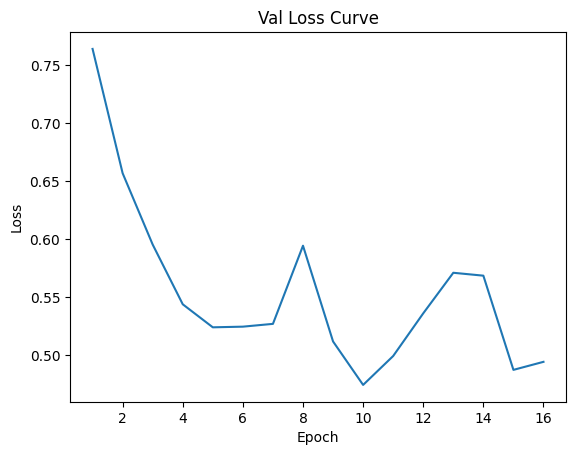

Finished Training Student for lambda value of 0
Student model SqueezeNet saved for lambda 0 to Smaller_Student_Models_13/models/SqueezeNet_lambda0_20231206_110838.pth
Weights saved for lambda 0 to Smaller_Student_Models_13/weights/SqueezeNet_weights_lambda0_20231206_110838.pth


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:19<00:00,  2.86it/s]


*****Epoch 1/100*****
*****Train Loss:  1.236081 Val Loss:  0.804898*****
*****Validation Accuracy: 22.74%*****
*****Total Avg Disparity: 0.041642017214753226*****

Class Team_Sports: Recall Difference = 0.020415624178862335
Class Celebration: Recall Difference = 0.04371287128712871
Class Parade: Recall Difference = 0.11553030303030304
Class Waiter_Or_Waitress: Recall Difference = 0.0
Class Individual_Sports: Recall Difference = 0.049742509363295884
Class Surgeons: Recall Difference = 0.0
Class Spa: Recall Difference = 0.0
Class Law_Enforcement: Recall Difference = 0.00704225352112676
Class Business: Recall Difference = 0.0
Class Dresses: Recall Difference = 0.0
Class Water_Activities: Recall Difference = -0.010964445390674905
Class Picnic: Recall Difference = 0.0
Class Rescue: Recall Difference = 0.0
Class Cheering: Recall Difference = 0.0
Class Performance_And_Entertainment: Recall Difference = 0.04408611373188095
Class Family: Recall Difference = 0.0
Data has been appended to Smalle

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:19<00:00,  2.88it/s]


*****Epoch 2/100*****
*****Train Loss:  1.179001 Val Loss:  0.762727*****
*****Validation Accuracy: 24.96%*****
*****Total Avg Disparity: 0.04734002032056428*****

Class Team_Sports: Recall Difference = 0.058881996092812805
Class Celebration: Recall Difference = -0.004999999999999999
Class Parade: Recall Difference = -0.07386363636363624
Class Waiter_Or_Waitress: Recall Difference = -0.06185567010309278
Class Individual_Sports: Recall Difference = 0.021145443196004865
Class Surgeons: Recall Difference = 0.0
Class Spa: Recall Difference = 0.0
Class Law_Enforcement: Recall Difference = 0.0018779342723004716
Class Business: Recall Difference = -0.1151921643777281
Class Dresses: Recall Difference = 0.0
Class Water_Activities: Recall Difference = 0.03544815839897808
Class Picnic: Recall Difference = 0.0
Class Rescue: Recall Difference = 0.0
Class Cheering: Recall Difference = 0.0
Class Performance_And_Entertainment: Recall Difference = 0.08071018097607002
Class Family: Recall Difference = 0

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:19<00:00,  2.83it/s]


*****Epoch 3/100*****
*****Train Loss:  1.125958 Val Loss:  0.745143*****
*****Validation Accuracy: 26.15%*****
*****Total Avg Disparity: 0.034755237062824615*****

Class Team_Sports: Recall Difference = 0.021820840616467385
Class Celebration: Recall Difference = 0.009603960396039602
Class Parade: Recall Difference = -0.045454545454545414
Class Waiter_Or_Waitress: Recall Difference = -0.07483772432226043
Class Individual_Sports: Recall Difference = 0.01786828963795256
Class Surgeons: Recall Difference = 0.0
Class Spa: Recall Difference = 0.0
Class Law_Enforcement: Recall Difference = -0.04436619718309863
Class Business: Recall Difference = -0.03651655488129457
Class Dresses: Recall Difference = -0.041916167664670656
Class Water_Activities: Recall Difference = 0.027783691718117953
Class Picnic: Recall Difference = 0.0
Class Rescue: Recall Difference = 0.0
Class Cheering: Recall Difference = 0.0
Class Performance_And_Entertainment: Recall Difference = 0.00969208336907107
Class Family: Re

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:18<00:00,  2.90it/s]


*****Epoch 4/100*****
*****Train Loss:  1.099022 Val Loss:  0.743757*****
*****Validation Accuracy: 26.12%*****
*****Total Avg Disparity: 0.06288892583657361*****

Class Team_Sports: Recall Difference = 0.02013001108178819
Class Celebration: Recall Difference = -0.021386138613861405
Class Parade: Recall Difference = -0.0246212121212121
Class Waiter_Or_Waitress: Recall Difference = -0.050019091256204684
Class Individual_Sports: Recall Difference = 0.05852059925093628
Class Surgeons: Recall Difference = 0.0
Class Spa: Recall Difference = -0.06249999999999999
Class Law_Enforcement: Recall Difference = 0.020422535211267606
Class Business: Recall Difference = -0.03651655488129457
Class Dresses: Recall Difference = -0.22754491017964074
Class Water_Activities: Recall Difference = -0.03906748988716202
Class Picnic: Recall Difference = 0.0
Class Rescue: Recall Difference = 0.0
Class Cheering: Recall Difference = 0.0
Class Performance_And_Entertainment: Recall Difference = 0.1527575263744747
Cla

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:19<00:00,  2.87it/s]


*****Epoch 5/100*****
*****Train Loss:  1.084819 Val Loss:  0.717411*****
*****Validation Accuracy: 28.86%*****
*****Total Avg Disparity: 0.04875722201670852*****

Class Team_Sports: Recall Difference = -0.0020221407272853487
Class Celebration: Recall Difference = -0.04207920792079209
Class Parade: Recall Difference = -0.04640151515151503
Class Waiter_Or_Waitress: Recall Difference = -0.07254677357770137
Class Individual_Sports: Recall Difference = 0.060549313358302215
Class Surgeons: Recall Difference = 0.018477457501847747
Class Spa: Recall Difference = -0.020833333333333332
Class Law_Enforcement: Recall Difference = -0.016197183098591555
Class Business: Recall Difference = -0.09283508996060895
Class Dresses: Recall Difference = -0.05389221556886227
Class Water_Activities: Recall Difference = -0.08090270385352355
Class Picnic: Recall Difference = 0.1437908496732026
Class Rescue: Recall Difference = 0.0
Class Cheering: Recall Difference = 0.0
Class Performance_And_Entertainment: Recal

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:19<00:00,  2.85it/s]


*****Epoch 6/100*****
*****Train Loss:  1.070104 Val Loss:  0.707693*****
*****Validation Accuracy: 30.88%*****
*****Total Avg Disparity: 0.060559195124216876*****

Class Team_Sports: Recall Difference = 0.058779175377866144
Class Celebration: Recall Difference = 0.009108910891089117
Class Parade: Recall Difference = -0.06344696969696972
Class Waiter_Or_Waitress: Recall Difference = -0.0912562046582665
Class Individual_Sports: Recall Difference = 0.03952091136079905
Class Surgeons: Recall Difference = 0.012564671101256461
Class Spa: Recall Difference = -0.12499999999999999
Class Law_Enforcement: Recall Difference = 0.050938967136150204
Class Business: Recall Difference = -0.06653891195571171
Class Dresses: Recall Difference = -0.06686626746506988
Class Water_Activities: Recall Difference = -0.0829252714498615
Class Picnic: Recall Difference = 0.1241830065359477
Class Rescue: Recall Difference = 0.0
Class Cheering: Recall Difference = 0.0
Class Performance_And_Entertainment: Recall Diff

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:19<00:00,  2.82it/s]


*****Epoch 7/100*****
*****Train Loss:  1.058960 Val Loss:  0.701454*****
*****Validation Accuracy: 31.17%*****
*****Total Avg Disparity: 0.04383784293206615*****

Class Team_Sports: Recall Difference = 0.0729455849927454
Class Celebration: Recall Difference = -0.006386138613861364
Class Parade: Recall Difference = -0.009469696969697072
Class Waiter_Or_Waitress: Recall Difference = -0.09125620465826656
Class Individual_Sports: Recall Difference = 0.012757490636704172
Class Surgeons: Recall Difference = 0.01847745750184774
Class Spa: Recall Difference = -0.041666666666666664
Class Law_Enforcement: Recall Difference = 0.01971830985915493
Class Business: Recall Difference = -0.10135207069094004
Class Dresses: Recall Difference = -0.1327345309381238
Class Water_Activities: Recall Difference = -0.0044709388971683195
Class Picnic: Recall Difference = -0.006535947712418305
Class Rescue: Recall Difference = 0.0
Class Cheering: Recall Difference = 0.0
Class Performance_And_Entertainment: Recall

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:19<00:00,  2.85it/s]


*****Epoch 8/100*****
*****Train Loss:  1.048846 Val Loss:  0.696290*****
*****Validation Accuracy: 31.17%*****
*****Total Avg Disparity: 0.06231112764016176*****

Class Team_Sports: Recall Difference = 0.052941243673669924
Class Celebration: Recall Difference = -0.015990099009900977
Class Parade: Recall Difference = -0.035037878787878896
Class Waiter_Or_Waitress: Recall Difference = -0.0828560519282169
Class Individual_Sports: Recall Difference = 0.09098002496878904
Class Surgeons: Recall Difference = 0.012564671101256475
Class Spa: Recall Difference = -0.1875
Class Law_Enforcement: Recall Difference = 0.050469483568075096
Class Business: Recall Difference = -0.05834131800276801
Class Dresses: Recall Difference = -0.08483033932135728
Class Water_Activities: Recall Difference = -0.07270598254204808
Class Picnic: Recall Difference = -0.01307189542483661
Class Rescue: Recall Difference = 0.0
Class Cheering: Recall Difference = 0.02884615384615384
Class Performance_And_Entertainment: Reca

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:19<00:00,  2.83it/s]


*****Epoch 9/100*****
*****Train Loss:  1.038868 Val Loss:  0.692840*****
*****Validation Accuracy: 32.38%*****
*****Total Avg Disparity: 0.07441979148544772*****

Class Team_Sports: Recall Difference = 0.05144463104500108
Class Celebration: Recall Difference = -0.0011881188118811753
Class Parade: Recall Difference = -0.025568181818181823
Class Waiter_Or_Waitress: Recall Difference = -0.11187476135929747
Class Individual_Sports: Recall Difference = 0.010923845193508142
Class Surgeons: Recall Difference = 0.01847745750184774
Class Spa: Recall Difference = -0.041666666666666664
Class Law_Enforcement: Recall Difference = 0.029107981220657275
Class Business: Recall Difference = -0.05578622378366871
Class Dresses: Recall Difference = -0.2874251497005988
Class Water_Activities: Recall Difference = -0.17383436235895244
Class Picnic: Recall Difference = 0.1633986928104575
Class Rescue: Recall Difference = 0.0
Class Cheering: Recall Difference = 0.0
Class Performance_And_Entertainment: Recall D

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:19<00:00,  2.85it/s]


*****Epoch 10/100*****
*****Train Loss:  1.028446 Val Loss:  0.694639*****
*****Validation Accuracy: 31.72%*****
*****Total Avg Disparity: 0.059386353935297245*****

Class Team_Sports: Recall Difference = 0.047354651494898925
Class Celebration: Recall Difference = 0.024108910891089116
Class Parade: Recall Difference = -0.016098484848484806
Class Waiter_Or_Waitress: Recall Difference = -0.10958381061473843
Class Individual_Sports: Recall Difference = -0.04053526841448185
Class Surgeons: Recall Difference = 0.03695491500369549
Class Spa: Recall Difference = -0.14583333333333331
Class Law_Enforcement: Recall Difference = 0.019718309859154917
Class Business: Recall Difference = -0.08069839241988713
Class Dresses: Recall Difference = -0.20359281437125748
Class Water_Activities: Recall Difference = -0.04268682137534596
Class Picnic: Recall Difference = 0.0718954248366013
Class Rescue: Recall Difference = 0.0
Class Cheering: Recall Difference = 0.009615384615384614
Class Performance_And_Enter

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:19<00:00,  2.89it/s]


*****Epoch 11/100*****
*****Train Loss:  1.020654 Val Loss:  0.695709*****
*****Validation Accuracy: 31.98%*****
*****Total Avg Disparity: 0.07629426435851304*****

Class Team_Sports: Recall Difference = 0.039871588351555354
Class Celebration: Recall Difference = 0.048316831683168346
Class Parade: Recall Difference = 0.010416666666666685
Class Waiter_Or_Waitress: Recall Difference = -0.19434898816342117
Class Individual_Sports: Recall Difference = 0.06831304619225964
Class Surgeons: Recall Difference = -0.01773835920177383
Class Spa: Recall Difference = -0.1875
Class Law_Enforcement: Recall Difference = -0.01549295774647888
Class Business: Recall Difference = -0.0849568827850527
Class Dresses: Recall Difference = -0.09081836327345313
Class Water_Activities: Recall Difference = -0.10751543538428787
Class Picnic: Recall Difference = 0.04575163398692808
Class Rescue: Recall Difference = 0.0
Class Cheering: Recall Difference = 0.0
Class Performance_And_Entertainment: Recall Difference = 0.

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:19<00:00,  2.85it/s]


*****Epoch 12/100*****
*****Train Loss:  1.010242 Val Loss:  0.686775*****
*****Validation Accuracy: 33.28%*****
*****Total Avg Disparity: 0.05969746740741017*****

Class Team_Sports: Recall Difference = -0.001827923821274613
Class Celebration: Recall Difference = -0.0164851485148515
Class Parade: Recall Difference = -0.030303030303030387
Class Waiter_Or_Waitress: Recall Difference = -0.14891179839633448
Class Individual_Sports: Recall Difference = 0.09975811485642949
Class Surgeons: Recall Difference = 0.03695491500369549
Class Spa: Recall Difference = -0.08333333333333333
Class Law_Enforcement: Recall Difference = 0.05798122065727701
Class Business: Recall Difference = -0.12796763547322476
Class Dresses: Recall Difference = -0.08483033932135733
Class Water_Activities: Recall Difference = -0.12263146689376209
Class Picnic: Recall Difference = 0.0522875816993464
Class Rescue: Recall Difference = 0.0
Class Cheering: Recall Difference = -0.016775777414075294
Class Performance_And_Enterta

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:19<00:00,  2.85it/s]


*****Epoch 13/100*****
*****Train Loss:  1.001937 Val Loss:  0.682512*****
*****Validation Accuracy: 32.61%*****
*****Total Avg Disparity: 0.06914686759211215*****

Class Team_Sports: Recall Difference = 0.08097702528247136
Class Celebration: Recall Difference = 0.0784158415841584
Class Parade: Recall Difference = -0.01988636363636359
Class Waiter_Or_Waitress: Recall Difference = -0.2107674684994273
Class Individual_Sports: Recall Difference = -0.024617665418227186
Class Surgeons: Recall Difference = 0.042867701404286765
Class Spa: Recall Difference = -0.1875
Class Law_Enforcement: Recall Difference = -0.022065727699530524
Class Business: Recall Difference = -0.06430320451399973
Class Dresses: Recall Difference = -0.0788423153692615
Class Water_Activities: Recall Difference = -0.11102831594634882
Class Picnic: Recall Difference = 0.0522875816993464
Class Rescue: Recall Difference = 0.0
Class Cheering: Recall Difference = 0.007569558101472997
Class Performance_And_Entertainment: Recall 

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:19<00:00,  2.89it/s]


*****Epoch 14/100*****
*****Train Loss:  0.992872 Val Loss:  0.683066*****
*****Validation Accuracy: 33.22%*****
*****Total Avg Disparity: 0.0850091329634011*****

Class Team_Sports: Recall Difference = 0.021866538711999062
Class Celebration: Recall Difference = -0.006386138613861392
Class Parade: Recall Difference = -0.05018939393939381
Class Waiter_Or_Waitress: Recall Difference = -0.20656739213440245
Class Individual_Sports: Recall Difference = 0.06136860174781528
Class Surgeons: Recall Difference = -0.114560236511456
Class Spa: Recall Difference = -0.2708333333333333
Class Law_Enforcement: Recall Difference = 0.076056338028169
Class Business: Recall Difference = -0.0849568827850527
Class Dresses: Recall Difference = 0.009980039920159667
Class Water_Activities: Recall Difference = -0.09250585480093682
Class Picnic: Recall Difference = 0.1830065359477124
Class Rescue: Recall Difference = 0.0
Class Cheering: Recall Difference = 0.018207855973813414
Class Performance_And_Entertainment:

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:19<00:00,  2.88it/s]


*****Epoch 15/100*****
*****Train Loss:  0.985319 Val Loss:  0.676837*****
*****Validation Accuracy: 33.80%*****
*****Total Avg Disparity: 0.06558248447820325*****

Class Team_Sports: Recall Difference = 0.08831156961533632
Class Celebration: Recall Difference = -0.036188118811881206
Class Parade: Recall Difference = -0.009469696969696961
Class Waiter_Or_Waitress: Recall Difference = -0.10805651011836576
Class Individual_Sports: Recall Difference = 0.062187890137328394
Class Surgeons: Recall Difference = 0.03695491500369549
Class Spa: Recall Difference = -0.16666666666666666
Class Law_Enforcement: Recall Difference = -0.008685446009389697
Class Business: Recall Difference = -0.07250079846694346
Class Dresses: Recall Difference = -0.2405189620758483
Class Water_Activities: Recall Difference = -0.05365126676602089
Class Picnic: Recall Difference = 0.065359477124183
Class Rescue: Recall Difference = -0.022727272727272724
Class Cheering: Recall Difference = 0.014116202945990176
Class Perfo

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:19<00:00,  2.87it/s]


*****Epoch 16/100*****
*****Train Loss:  0.976594 Val Loss:  0.666929*****
*****Validation Accuracy: 35.06%*****
*****Total Avg Disparity: 0.06197534515674375*****

Class Team_Sports: Recall Difference = 0.016279946533228284
Class Celebration: Recall Difference = -0.0260891089108911
Class Parade: Recall Difference = -0.015151515151515083
Class Waiter_Or_Waitress: Recall Difference = -0.19625811378388694
Class Individual_Sports: Recall Difference = 0.030937890137328394
Class Surgeons: Recall Difference = -0.02365114560236513
Class Spa: Recall Difference = -0.18749999999999997
Class Law_Enforcement: Recall Difference = 0.06478873239436611
Class Business: Recall Difference = -0.08240178856595337
Class Dresses: Recall Difference = -0.12075848303393213
Class Water_Activities: Recall Difference = -0.08303172237598472
Class Picnic: Recall Difference = -0.01307189542483661
Class Rescue: Recall Difference = -0.022727272727272724
Class Cheering: Recall Difference = -0.002045826513911622
Class Pe

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:19<00:00,  2.88it/s]


*****Epoch 17/100*****
*****Train Loss:  0.963140 Val Loss:  0.678482*****
*****Validation Accuracy: 34.26%*****
*****Total Avg Disparity: 0.08804000867978863*****

Class Team_Sports: Recall Difference = 0.041516719790702594
Class Celebration: Recall Difference = 0.052623762376237615
Class Parade: Recall Difference = -0.038825757575757514
Class Waiter_Or_Waitress: Recall Difference = -0.17563955708285606
Class Individual_Sports: Recall Difference = 0.08832709113607995
Class Surgeons: Recall Difference = 0.025129342202512922
Class Spa: Recall Difference = -0.2708333333333333
Class Law_Enforcement: Recall Difference = 0.0453051643192488
Class Business: Recall Difference = -0.1146598530820824
Class Dresses: Recall Difference = -0.2225548902195609
Class Water_Activities: Recall Difference = -0.0706834149457099
Class Picnic: Recall Difference = 0.04575163398692808
Class Rescue: Recall Difference = 0.0
Class Cheering: Recall Difference = -0.011661211129296235
Class Performance_And_Entertainm

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:19<00:00,  2.85it/s]


*****Epoch 18/100*****
*****Train Loss:  0.958087 Val Loss:  0.673823*****
*****Validation Accuracy: 34.55%*****
*****Total Avg Disparity: 0.08828669012616283*****

Class Team_Sports: Recall Difference = 0.10182678136888651
Class Celebration: Recall Difference = 0.02420792079207918
Class Parade: Recall Difference = -0.028409090909090995
Class Waiter_Or_Waitress: Recall Difference = -0.18823978617793047
Class Individual_Sports: Recall Difference = 0.0407303370786517
Class Surgeons: Recall Difference = -0.035476718403547686
Class Spa: Recall Difference = -0.29166666666666663
Class Law_Enforcement: Recall Difference = 0.02441314553990609
Class Business: Recall Difference = -0.0578090067071223
Class Dresses: Recall Difference = -0.19860279441117765
Class Water_Activities: Recall Difference = -0.14796678731104956
Class Picnic: Recall Difference = -0.12418300653594772
Class Rescue: Recall Difference = -0.022727272727272724
Class Cheering: Recall Difference = 0.017184942716857613
Class Perfor

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:19<00:00,  2.85it/s]


*****Epoch 19/100*****
*****Train Loss:  0.947953 Val Loss:  0.666399*****
*****Validation Accuracy: 35.93%*****
*****Total Avg Disparity: 0.06724427329760457*****

Class Team_Sports: Recall Difference = 0.07339114142418113
Class Celebration: Recall Difference = 0.023811881188118805
Class Parade: Recall Difference = 0.032196969696969724
Class Waiter_Or_Waitress: Recall Difference = -0.13669339442535322
Class Individual_Sports: Recall Difference = 0.04584113607990009
Class Surgeons: Recall Difference = 0.006651884700665189
Class Spa: Recall Difference = -0.22916666666666669
Class Law_Enforcement: Recall Difference = 0.055164319248826255
Class Business: Recall Difference = -0.03715532843606939
Class Dresses: Recall Difference = -0.2694610778443114
Class Water_Activities: Recall Difference = -0.02363210559931861
Class Picnic: Recall Difference = 0.006535947712418277
Class Rescue: Recall Difference = -0.04545454545454545
Class Cheering: Recall Difference = -0.011252045826513915
Class Perfo

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:19<00:00,  2.85it/s]


*****Epoch 20/100*****
*****Train Loss:  0.941294 Val Loss:  0.671120*****
*****Validation Accuracy: 34.72%*****
*****Total Avg Disparity: 0.07091946160169793*****

Class Team_Sports: Recall Difference = 0.10576824210851005
Class Celebration: Recall Difference = 0.04683168316831682
Class Parade: Recall Difference = 0.009469696969696961
Class Waiter_Or_Waitress: Recall Difference = -0.21496754486445208
Class Individual_Sports: Recall Difference = 0.03991104868913853
Class Surgeons: Recall Difference = -0.05986696230598669
Class Spa: Recall Difference = -0.29166666666666663
Class Law_Enforcement: Recall Difference = 0.03544600938967135
Class Business: Recall Difference = -0.04279782816991379
Class Dresses: Recall Difference = -0.11576846307385225
Class Water_Activities: Recall Difference = -0.01266766020864385
Class Picnic: Recall Difference = -0.052287581699346386
Class Rescue: Recall Difference = -0.022727272727272724
Class Cheering: Recall Difference = 0.01820785597381342
Class Perfor

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:18<00:00,  2.90it/s]


*****Epoch 21/100*****
*****Train Loss:  0.932096 Val Loss:  0.670764*****
*****Validation Accuracy: 34.83%*****
*****Total Avg Disparity: 0.07547334769062984*****

Class Team_Sports: Recall Difference = 0.11514777621642613
Class Celebration: Recall Difference = 0.057227722772277195
Class Parade: Recall Difference = -0.004734848484848508
Class Waiter_Or_Waitress: Recall Difference = -0.1676212294768996
Class Individual_Sports: Recall Difference = 0.009480337078651646
Class Surgeons: Recall Difference = 0.0066518847006651755
Class Spa: Recall Difference = -0.3125
Class Law_Enforcement: Recall Difference = 0.07206572769953051
Class Business: Recall Difference = -0.08325348663898646
Class Dresses: Recall Difference = -0.16267465069860285
Class Water_Activities: Recall Difference = 0.022780498190334453
Class Picnic: Recall Difference = -0.026143790849673193
Class Rescue: Recall Difference = 0.047860962566844925
Class Cheering: Recall Difference = 0.0333469721767594
Class Performance_And_En

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:19<00:00,  2.89it/s]


*****Epoch 22/100*****
*****Train Loss:  0.922668 Val Loss:  0.666564*****
*****Validation Accuracy: 35.30%*****
*****Total Avg Disparity: 0.07884375729634525*****

Class Team_Sports: Recall Difference = 0.11474791788052235
Class Celebration: Recall Difference = -0.011386138613861396
Class Parade: Recall Difference = -0.017045454545454586
Class Waiter_Or_Waitress: Recall Difference = -0.1676212294768996
Class Individual_Sports: Recall Difference = -0.008700062421972521
Class Surgeons: Recall Difference = -0.01108647450110864
Class Spa: Recall Difference = -0.2708333333333333
Class Law_Enforcement: Recall Difference = -0.05751173708920193
Class Business: Recall Difference = -0.03715532843606939
Class Dresses: Recall Difference = -0.3413173652694611
Class Water_Activities: Recall Difference = -0.009899936129444287
Class Picnic: Recall Difference = -0.052287581699346386
Class Rescue: Recall Difference = 0.02352941176470588
Class Cheering: Recall Difference = 0.002454991816693952
Class Per

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:18<00:00,  2.90it/s]


*****Epoch 23/100*****
*****Train Loss:  0.916456 Val Loss:  0.666218*****
*****Validation Accuracy: 36.25%*****
*****Total Avg Disparity: 0.07752831910177643*****

Class Team_Sports: Recall Difference = 0.05772811918063314
Class Celebration: Recall Difference = -0.036287128712871264
Class Parade: Recall Difference = -0.058712121212121215
Class Waiter_Or_Waitress: Recall Difference = -0.09736540664375712
Class Individual_Sports: Recall Difference = 0.004798689138576839
Class Surgeons: Recall Difference = 0.0007390983000739038
Class Spa: Recall Difference = -0.24999999999999997
Class Law_Enforcement: Recall Difference = -0.03755868544600943
Class Business: Recall Difference = -0.0578090067071223
Class Dresses: Recall Difference = -0.36526946107784425
Class Water_Activities: Recall Difference = -0.09527357888013621
Class Picnic: Recall Difference = 0.039215686274509776
Class Rescue: Recall Difference = 0.023529411764705882
Class Cheering: Recall Difference = -0.02291325695581016
Class Pe

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:19<00:00,  2.87it/s]


*****Epoch 24/100*****
*****Train Loss:  0.908707 Val Loss:  0.678889*****
*****Validation Accuracy: 34.72%*****
*****Total Avg Disparity: 0.0666568400801408*****

Class Team_Sports: Recall Difference = 0.15889227816430745
Class Celebration: Recall Difference = 0.05252475247524757
Class Parade: Recall Difference = 0.029356060606060552
Class Waiter_Or_Waitress: Recall Difference = -0.22718594883543333
Class Individual_Sports: Recall Difference = 0.0407303370786517
Class Surgeons: Recall Difference = -0.01108647450110864
Class Spa: Recall Difference = -0.22916666666666669
Class Law_Enforcement: Recall Difference = -0.005633802816901512
Class Business: Recall Difference = -0.003193867773874204
Class Dresses: Recall Difference = -0.07385229540918159
Class Water_Activities: Recall Difference = -0.0516286991696826
Class Picnic: Recall Difference = -0.026143790849673193
Class Rescue: Recall Difference = -0.02192513368983957
Class Cheering: Recall Difference = 0.02782324058919804
Class Perform

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:18<00:00,  2.90it/s]


*****Epoch 25/100*****
*****Train Loss:  0.899581 Val Loss:  0.675828*****
*****Validation Accuracy: 35.32%*****
*****Total Avg Disparity: 0.07850604215132011*****

Class Team_Sports: Recall Difference = 0.07388239595114865
Class Celebration: Recall Difference = 0.03871287128712872
Class Parade: Recall Difference = -0.03882575757575768
Class Waiter_Or_Waitress: Recall Difference = -0.12829324169530354
Class Individual_Sports: Recall Difference = 0.04521691635455677
Class Surgeons: Recall Difference = -0.016999260901699925
Class Spa: Recall Difference = -0.22916666666666666
Class Law_Enforcement: Recall Difference = 0.029812206572769923
Class Business: Recall Difference = 0.011817310763334365
Class Dresses: Recall Difference = -0.3293413173652695
Class Water_Activities: Recall Difference = -0.0454545454545453
Class Picnic: Recall Difference = 0.11764705882352938
Class Rescue: Recall Difference = 0.024331550802139036
Class Cheering: Recall Difference = 0.0034779050736497563
Class Perform

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:19<00:00,  2.85it/s]


*****Epoch 26/100*****
*****Train Loss:  0.893615 Val Loss:  0.664084*****
*****Validation Accuracy: 36.19%*****
*****Total Avg Disparity: 0.07824546294208265*****

Class Team_Sports: Recall Difference = 0.08211947767076799
Class Celebration: Recall Difference = -0.007178217821782212
Class Parade: Recall Difference = -0.02840909090909094
Class Waiter_Or_Waitress: Recall Difference = -0.1859488354333715
Class Individual_Sports: Recall Difference = 0.043383270911360794
Class Surgeons: Recall Difference = -0.01773835920177383
Class Spa: Recall Difference = -0.1875
Class Law_Enforcement: Recall Difference = 0.11478873239436621
Class Business: Recall Difference = 0.005323112956456932
Class Dresses: Recall Difference = -0.20459081836327345
Class Water_Activities: Recall Difference = -0.0830317223759846
Class Picnic: Recall Difference = 0.05882352941176472
Class Rescue: Recall Difference = 0.0
Class Cheering: Recall Difference = 0.0024549918166939383
Class Performance_And_Entertainment: Recal

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:19<00:00,  2.86it/s]


*****Epoch 27/100*****
*****Train Loss:  0.885024 Val Loss:  0.673611*****
*****Validation Accuracy: 36.25%*****
*****Total Avg Disparity: 0.08534789838133508*****

Class Team_Sports: Recall Difference = 0.07798380002513394
Class Celebration: Recall Difference = -0.03688118811881194
Class Parade: Recall Difference = -0.026515151515151714
Class Waiter_Or_Waitress: Recall Difference = -0.18213058419243994
Class Individual_Sports: Recall Difference = 0.04849406991260918
Class Surgeons: Recall Difference = 0.031042128603104208
Class Spa: Recall Difference = -0.24999999999999997
Class Law_Enforcement: Recall Difference = 0.09107981220657274
Class Business: Recall Difference = -0.03119344192483764
Class Dresses: Recall Difference = -0.2105788423153693
Class Water_Activities: Recall Difference = -0.12880562060889927
Class Picnic: Recall Difference = -0.13071895424836605
Class Rescue: Recall Difference = 0.011764705882352941
Class Cheering: Recall Difference = -0.013707037643207853
Class Perfo

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:19<00:00,  2.87it/s]


*****Epoch 28/100*****
*****Train Loss:  0.875571 Val Loss:  0.691828*****
*****Validation Accuracy: 35.93%*****
*****Total Avg Disparity: 0.06527988207389182*****

Class Team_Sports: Recall Difference = 0.03892335286926918
Class Celebration: Recall Difference = -0.011683168316831666
Class Parade: Recall Difference = -0.0179924242424242
Class Waiter_Or_Waitress: Recall Difference = -0.17983963344788095
Class Individual_Sports: Recall Difference = 0.010923845193508142
Class Surgeons: Recall Difference = 0.043606799704360655
Class Spa: Recall Difference = -0.22916666666666666
Class Law_Enforcement: Recall Difference = 0.026760563380281682
Class Business: Recall Difference = -0.006600660066006625
Class Dresses: Recall Difference = -0.16267465069860285
Class Water_Activities: Recall Difference = -0.04407068341494563
Class Picnic: Recall Difference = 0.039215686274509776
Class Rescue: Recall Difference = 0.03529411764705882
Class Cheering: Recall Difference = -0.027414075286415714
Class Per

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:19<00:00,  2.89it/s]


*****Epoch 29/100*****
*****Train Loss:  0.870456 Val Loss:  0.676196*****
*****Validation Accuracy: 35.79%*****
*****Total Avg Disparity: 0.09717609336553522*****

Class Team_Sports: Recall Difference = 0.1442231894985777
Class Celebration: Recall Difference = -0.062277227722772194
Class Parade: Recall Difference = -0.06534090909090912
Class Waiter_Or_Waitress: Recall Difference = -0.16953035509736533
Class Individual_Sports: Recall Difference = 0.014591136079900091
Class Surgeons: Recall Difference = 0.07390983000739099
Class Spa: Recall Difference = -0.29166666666666663
Class Law_Enforcement: Recall Difference = 0.0981220657276996
Class Business: Recall Difference = -0.08719259022676465
Class Dresses: Recall Difference = -0.32934131736526945
Class Water_Activities: Recall Difference = -0.10964445390674898
Class Picnic: Recall Difference = -0.0326797385620915
Class Rescue: Recall Difference = 0.011764705882352941
Class Cheering: Recall Difference = -0.0006137479541734742
Class Perfor

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:19<00:00,  2.84it/s]


*****Epoch 30/100*****
*****Train Loss:  0.864878 Val Loss:  0.680847*****
*****Validation Accuracy: 35.47%*****
*****Total Avg Disparity: 0.09206165981528783*****

Class Team_Sports: Recall Difference = 0.1194319726725388
Class Celebration: Recall Difference = -0.027772277227722797
Class Parade: Recall Difference = -0.045454545454545525
Class Waiter_Or_Waitress: Recall Difference = -0.23558610156548299
Class Individual_Sports: Recall Difference = 0.021535580524344622
Class Surgeons: Recall Difference = 0.10421286031042126
Class Spa: Recall Difference = -0.29166666666666663
Class Law_Enforcement: Recall Difference = 0.02723004694835679
Class Business: Recall Difference = 0.0019163206643244557
Class Dresses: Recall Difference = -0.2934131736526946
Class Water_Activities: Recall Difference = -0.037151373216947
Class Picnic: Recall Difference = -0.07189542483660133
Class Rescue: Recall Difference = 0.047058823529411764
Class Cheering: Recall Difference = 0.02782324058919803
Class Performa

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:18<00:00,  2.90it/s]


*****Epoch 31/100*****
*****Train Loss:  0.855368 Val Loss:  0.670072*****
*****Validation Accuracy: 35.61%*****
*****Total Avg Disparity: 0.08782515436255095*****

Class Team_Sports: Recall Difference = 0.07484205595731802
Class Celebration: Recall Difference = -0.03198019801980198
Class Parade: Recall Difference = 0.006628787878787734
Class Waiter_Or_Waitress: Recall Difference = -0.10996563573883167
Class Individual_Sports: Recall Difference = 0.020092072409488126
Class Surgeons: Recall Difference = 0.11677753141167782
Class Spa: Recall Difference = -0.22916666666666666
Class Law_Enforcement: Recall Difference = 0.11361502347417846
Class Business: Recall Difference = -0.02129245182582773
Class Dresses: Recall Difference = -0.33532934131736525
Class Water_Activities: Recall Difference = -0.05982542048115813
Class Picnic: Recall Difference = -0.052287581699346386
Class Rescue: Recall Difference = 0.05882352941176471
Class Cheering: Recall Difference = 0.034369885433715226
Class Perfor

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:19<00:00,  2.87it/s]


*****Epoch 32/100*****
*****Train Loss:  0.846531 Val Loss:  0.682461*****
*****Validation Accuracy: 36.16%*****
*****Total Avg Disparity: 0.07336364430278672*****

Class Team_Sports: Recall Difference = 0.08426728816076579
Class Celebration: Recall Difference = 0.0076237623762376305
Class Parade: Recall Difference = -0.017045454545454586
Class Waiter_Or_Waitress: Recall Difference = -0.08514700267277586
Class Individual_Sports: Recall Difference = 0.026841448189762862
Class Surgeons: Recall Difference = 0.019216555801921692
Class Spa: Recall Difference = -0.29166666666666663
Class Law_Enforcement: Recall Difference = 0.06690140845070425
Class Business: Recall Difference = 0.0024486319599701933
Class Dresses: Recall Difference = -0.2934131736526946
Class Water_Activities: Recall Difference = -0.005854800936768045
Class Picnic: Recall Difference = -0.052287581699346386
Class Rescue: Recall Difference = 0.05882352941176471
Class Cheering: Recall Difference = 0.013093289689034365
Class Pe

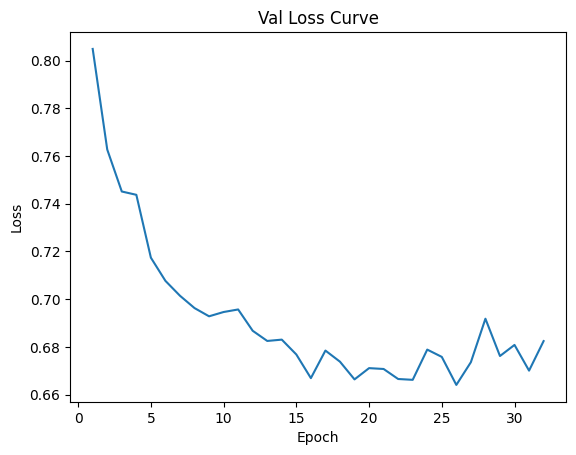

Finished Training Student for lambda value of 0
Student model CustomSmallCNN saved for lambda 0 to Smaller_Student_Models_13/models/CustomSmallCNN_lambda0_20231206_112959.pth
Weights saved for lambda 0 to Smaller_Student_Models_13/weights/CustomSmallCNN_weights_lambda0_20231206_112959.pth


In [31]:
# Loop for training the student model with different lambda values
for i in lmda_list_student:
    # Load the teacher model with lambda 0
    teacher_model_path = os.path.join(output_dir, 'teacher_model_ckd_wider_lambda0.pth')
    teacher_model = torch.load(teacher_model_path)
    teacher_model_weights_path = os.path.join(output_dir, 'teacher_model_weights_ckd_wider_lambda0.pth')
    teacher_model.load_state_dict(torch.load(teacher_model_weights_path))
    teacher_model = teacher_model.to(device)
        
    for student_model in student_models:
        model_name = type(student_model).__name__
        timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
        model_filename = f"{model_name}_lambda{i}_{timestamp}.pth"
        weights_filename = f"{model_name}_weights_lambda{i}_{timestamp}.pth"

        # Reset the optimizer for the student model for each lambda
        student_optimizer = optim.Adam(student_model.parameters(), lr=best_lr_student)
        
        # Initialize the adversary
        adv = Adversary()
        student_optimizer_adv = optim.Adam(adv.parameters(), lr=learning_rate)
        
        # Pretrain student and adversary if i != 0
        if i != 0:
            pretrain_student(student_model, teacher_model, trainloader, criterion_clf, student_optimizer, device, alpha, temperature, epochs_pretrain)
            pretrain_adversary(adv, teacher_model, optimizer_adv, trainloader, adv_criterion, device, epochs_pretrain)
        
        # Train the student model with knowledge distillation and disparity reduction
        student_mean_abs_val_disparity = train_student_with_distillation_disparity(student_model, teacher_model, adv, trainloader, testloader, criterion_clf, 
                                                                                   adv_criterion, student_optimizer, student_optimizer_adv, device, alpha, 
                                                                                   temperature, epochs, lmda=i, patience=patience_student)
    
        # Save the trained student model and its weights
        model_save_path = os.path.join(models_dir, model_filename)
        weights_save_path = os.path.join(weights_dir, weights_filename)
    
        torch.save(student_model, model_save_path)
        torch.save(student_model.state_dict(), weights_save_path)
    
        print(f"Student model {model_name} saved for lambda {i} to {model_save_path}")
        print(f"Weights saved for lambda {i} to {weights_save_path}")
    
        # Update the dictionary with the student results
        if i not in lambda_results:
            lambda_results[i] = {model_name: {'student_mean_abs_val_disparity': student_mean_abs_val_disparity}}
        else:
            if model_name not in lambda_results[i]:
                lambda_results[i][model_name] = {'student_mean_abs_val_disparity': student_mean_abs_val_disparity}
            else:
                lambda_results[i][model_name].update({'student_mean_abs_val_disparity': student_mean_abs_val_disparity})


In [32]:
def compare_performance_metrics(teacher, student, dataloader):
    teacher.eval()
    student.eval()
    
    all_labels = []
    all_teacher_preds = []
    all_student_preds = []

    for batch in dataloader:
        inputs = batch['img'].to(device)
        labels = batch['label'].to(device)
        
        with torch.no_grad():
            teacher_outputs = teacher(inputs)
            student_outputs = student(inputs)
            
        teacher_preds = torch.argmax(teacher_outputs, dim=1).cpu().numpy()
        student_preds = torch.argmax(student_outputs, dim=1).cpu().numpy()
        
        all_labels.append(labels.cpu().numpy())
        all_teacher_preds.append(teacher_preds)
        all_student_preds.append(student_preds)

    all_labels = np.concatenate(all_labels)
    all_teacher_preds = np.concatenate(all_teacher_preds)
    all_student_preds = np.concatenate(all_student_preds)
    
    metrics = {
        'accuracy': (accuracy_score(all_labels, all_teacher_preds), accuracy_score(all_labels, all_student_preds)),
        'precision': (precision_score(all_labels, all_teacher_preds, average='weighted', zero_division=0), precision_score(all_labels, all_student_preds, average='weighted', zero_division=0)),
        'recall': (recall_score(all_labels, all_teacher_preds, average='weighted'), recall_score(all_labels, all_student_preds, average='weighted')),
        'f1': (f1_score(all_labels, all_teacher_preds, average='weighted'), f1_score(all_labels, all_student_preds, average='weighted'))
    }

    return {
        'metrics': metrics,
        'all_labels': all_labels,
        'all_teacher_preds': all_teacher_preds,
        'all_student_preds': all_student_preds
    }

def compare_model_size(teacher, student):
    teacher_params = sum(p.numel() for p in teacher.parameters())
    student_params = sum(p.numel() for p in student.parameters())
    return teacher_params, student_params

def compare_inference_time(teacher, student, dataloader):
    dataiter = iter(dataloader)
    data = next(dataiter)
    inputs = data['img']
    inputs = inputs.to(device)

    teacher_time, student_time = 0, 0

    if teacher is not None:
        teacher = teacher.to(device)
        start_time = time.time()
        with torch.no_grad():
            teacher_outputs = teacher(inputs)
        teacher_time = time.time() - start_time

    if student is not None:
        student = student.to(device)
        start_time = time.time()
        with torch.no_grad():
            student_outputs = student(inputs)
        student_time = time.time() - start_time
    
    return teacher_time, student_time


In [33]:
# Loop through each lambda value
for lmda_teacher in lmda_list_teacher:
    for lmda_student in lmda_list_student:

        # Load the teacher model for the current lambda from the 'output_dir'
        teacher_model_path = os.path.join(output_dir, f'teacher_model_ckd_wider_lambda{lmda_teacher}.pth')
        teacher_model = torch.load(teacher_model_path)
        
        # Load the student model for the current lambda from the 'output_dir'
        student_model_path = os.path.join(output_dir, f'student_model_ckd_wider_lambda{lmda_student}.pth')
        student_model = torch.load(student_model_path)
    
        # Compute performance metrics
        performance_metrics = compare_performance_metrics(teacher_model, student_model, testloader)
    
        # Compute model sizes
        teacher_params, student_params = compare_model_size(teacher_model, student_model)
    
        # Construct a unique key for the current combination of lambda values
        lambda_key = (lmda_teacher, lmda_student)

        # Update results for the current lambda value
        if lambda_key in lambda_results:
            lambda_results[lambda_key].update({
                'performance_metrics': performance_metrics,
                'teacher_params': teacher_params,
                'student_params': student_params
            })
        else:
            lambda_results[lambda_key] = {
                'performance_metrics': performance_metrics,
                'teacher_params': teacher_params,
                'student_params': student_params
            }


FileNotFoundError: [Errno 2] No such file or directory: 'Smaller_Student_Models_13/student_model_ckd_wider_lambda0.pth'

In [ ]:
# Initialize lists to store accuracies
teacher_accuracies = []
student_accuracies = []
lambda_pairs = list(lambda_results.keys())

# Iterate over the keys in lambda_results
for key in lambda_pairs:
    # Check if the key is a tuple (indicating a lambda pair)
    if isinstance(key, tuple) and len(key) == 2:
        lmda_teacher, lmda_student = key
    else:
        # If the key is not a tuple, skip this iteration
        continue

    # Access the performance metrics for each pair
    teacher_accuracy = lambda_results[(lmda_teacher, lmda_student)]['performance_metrics']['metrics']['accuracy'][0]
    student_accuracy = lambda_results[(lmda_teacher, lmda_student)]['performance_metrics']['metrics']['accuracy'][1]

    # Append accuracies to the lists
    teacher_accuracies.append((lmda_teacher, teacher_accuracy))
    student_accuracies.append((lmda_student, student_accuracy))

# To plot, you might need to separate the lambda values and accuracies
teacher_lambdas, teacher_acc = zip(*teacher_accuracies)
student_lambdas, student_acc = zip(*student_accuracies)

# Plotting only with markers and no lines
plt.scatter(teacher_lambdas, teacher_acc, label='Teacher Accuracy', marker='o')
plt.scatter(student_lambdas, student_acc, label='Student Accuracy', marker='o')

# Adding labels and title
plt.xlabel('Lambda')
plt.ylabel('Accuracy')
plt.title('Accuracy Comparison Across Lambdas')
plt.legend()

# Show plot
plt.show()


In [ ]:
# Initialize lists to store precisions
teacher_precisions = []
student_precisions = []
lambda_pairs = list(lambda_results.keys())

# Iterate over the keys in lambda_results
for key in lambda_pairs:
    # Check if the key is a tuple (indicating a lambda pair)
    if isinstance(key, tuple) and len(key) == 2:
        lmda_teacher, lmda_student = key
        # Access the precision metrics for each pair
        teacher_precision = lambda_results[(lmda_teacher, lmda_student)]['performance_metrics']['metrics']['precision'][0]
        student_precision = lambda_results[(lmda_teacher, lmda_student)]['performance_metrics']['metrics']['precision'][1]
    else:
        # If the key is not a tuple, skip this iteration
        continue

    # Append precisions to the lists along with lambda values
    teacher_precisions.append((lmda_teacher, teacher_precision))
    student_precisions.append((lmda_student, student_precision))

# Extracting lambda values and precisions
teacher_lambdas, teacher_prec = zip(*teacher_precisions)
student_lambdas, student_prec = zip(*student_precisions)

# Creating a scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(teacher_lambdas, teacher_prec, label='Teacher Precision', marker='o')
plt.scatter(student_lambdas, student_prec, label='Student Precision', marker='o')

# Adding labels and title
plt.xlabel('Lambda')
plt.ylabel('Precision')
plt.title('Precision Comparison Across Lambdas')
plt.legend()

# Displaying the plot
plt.show()

In [ ]:
# Initialize lists to store recalls
teacher_recalls = []
student_recalls = []
lambda_pairs = list(lambda_results.keys())

# Iterate over the keys in lambda_results
for key in lambda_pairs:
    # Check if the key is a tuple (indicating a lambda pair)
    if isinstance(key, tuple) and len(key) == 2:
        lmda_teacher, lmda_student = key
        # Access the recall metrics for each pair
        teacher_recall = lambda_results[(lmda_teacher, lmda_student)]['performance_metrics']['metrics']['recall'][0]
        student_recall = lambda_results[(lmda_teacher, lmda_student)]['performance_metrics']['metrics']['recall'][1]
    else:
        # If the key is not a tuple, skip this iteration
        continue

    # Append recalls to the lists along with lambda values
    teacher_recalls.append((lmda_teacher, teacher_recall))
    student_recalls.append((lmda_student, student_recall))

# Extracting lambda values and recalls
teacher_lambdas, teacher_rec = zip(*teacher_recalls)
student_lambdas, student_rec = zip(*student_recalls)

# Creating a scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(teacher_lambdas, teacher_rec, label='Teacher Recall', marker='o')
plt.scatter(student_lambdas, student_rec, label='Student Recall', marker='o')

# Adding labels and title
plt.xlabel('Lambda')
plt.ylabel('Recall')
plt.title('Recall Comparison Across Lambdas')
plt.legend()

# Displaying the plot
plt.show()


In [ ]:
# Initialize lists to store F1 scores
teacher_f1s = []
student_f1s = []
lambda_pairs = list(lambda_results.keys())

# Iterate over the keys in lambda_results
for key in lambda_pairs:
    # Check if the key is a tuple (indicating a lambda pair)
    if isinstance(key, tuple) and len(key) == 2:
        lmda_teacher, lmda_student = key
        # Access the F1 scores for each pair
        teacher_f1 = lambda_results[(lmda_teacher, lmda_student)]['performance_metrics']['metrics']['f1'][0]
        student_f1 = lambda_results[(lmda_teacher, lmda_student)]['performance_metrics']['metrics']['f1'][1]
    else:
        # If the key is not a tuple, skip this iteration
        continue

    # Append F1 scores to the lists along with lambda values
    teacher_f1s.append((lmda_teacher, teacher_f1))
    student_f1s.append((lmda_student, student_f1))

# Extracting lambda values and F1 scores
teacher_lambdas, teacher_f1_scores = zip(*teacher_f1s)
student_lambdas, student_f1_scores = zip(*student_f1s)

# Creating a scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(teacher_lambdas, teacher_f1_scores, label='Teacher F1 Score', marker='o')
plt.scatter(student_lambdas, student_f1_scores, label='Student F1 Score', marker='o')

# Adding labels and title
plt.xlabel('Lambda')
plt.ylabel('F1 Score')
plt.title('F1 Score Comparison Across Lambdas')
plt.legend()

# Displaying the plot
plt.show()

In [ ]:
# Initialize lists to store model sizes
teacher_sizes = []
student_sizes = []
lambda_pairs = list(lambda_results.keys())

# Iterate over the keys in lambda_results
for key in lambda_pairs:
    # Check if the key is a tuple (indicating a lambda pair)
    if isinstance(key, tuple) and len(key) == 2:
        lmda_teacher, lmda_student = key
        # Access the model sizes for each pair
        teacher_size = lambda_results[(lmda_teacher, lmda_student)]['teacher_params'] / 1e6  # Convert to millions
        student_size = lambda_results[(lmda_teacher, lmda_student)]['student_params'] / 1e6
    else:
        # If the key is not a tuple, skip this iteration
        continue

    # Append model sizes to the lists along with lambda values
    teacher_sizes.append((lmda_teacher, teacher_size))
    student_sizes.append((lmda_student, student_size))

# Extracting lambda values and model sizes
teacher_lambdas, teacher_model_sizes = zip(*teacher_sizes)
student_lambdas, student_model_sizes = zip(*student_sizes)

# Creating a scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(teacher_lambdas, teacher_model_sizes, label='Teacher Model Size', marker='o')
plt.scatter(student_lambdas, student_model_sizes, label='Student Model Size', marker='o')

# Adding labels and title
plt.xlabel('Lambda')
plt.ylabel('Model Size (Millions of Parameters)')
plt.title('Model Size Comparison Across Lambdas')
plt.legend()

# Displaying the plot
plt.show()


In [ ]:
# Initialize dictionaries to store inference times for each lambda value
teacher_times = {}
student_times = {}

# Loop through each lambda value
for lmda_teacher in lmda_list_teacher:
    # Load the teacher model for the current lambda
    teacher_model_path = os.path.join(output_dir, f'teacher_model_ckd_wider_lambda{lmda_teacher}.pth')
    teacher_model = torch.load(teacher_model_path)

    teacher_time, _ = compare_inference_time(teacher_model, None, testloader)
    teacher_times[lmda_teacher] = teacher_time  # Store the inference time for the teacher model

for lmda_student in lmda_list_student:
    # Load the student model for the current lambda
    student_model_path = os.path.join(output_dir, f'student_model_ckd_wider_lambda{lmda_student}.pth')
    student_model = torch.load(student_model_path)

    _, student_time = compare_inference_time(None, student_model, testloader)
    student_times[lmda_student] = student_time  # Store the inference time for the student model

# Extracting lambda values and inference times
teacher_lambdas, teacher_inference_times = zip(*teacher_times.items())
student_lambdas, student_inference_times = zip(*student_times.items())

# Creating a scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(teacher_lambdas, teacher_inference_times, label='Teacher Inference Time', marker='o')
plt.scatter(student_lambdas, student_inference_times, label='Student Inference Time', marker='o')

# Adding labels and title
plt.xlabel('Lambda')
plt.ylabel('Inference Time (s)')
plt.title('Inference Time Comparison Across Lambdas')
plt.legend()

# Displaying the plot
plt.show()

In [ ]:
# Initialize lists to store disparity values
teacher_disparities = []
student_disparities = []
lambda_pairs = list(lambda_results.keys())

# Iterate over the keys in lambda_results
for key in lambda_pairs:
    # Check if it's an integer key (indicating a lambda value for student)
    if isinstance(key, int):
        # Check and extract teacher disparity if it exists
        if 'teacher_mean_abs_val_disparity' in lambda_results[key]:
            teacher_disparity = lambda_results[key]['teacher_mean_abs_val_disparity']
            # Take the last value if there are multiple
            teacher_disparity = teacher_disparity[-1] if isinstance(teacher_disparity, list) else teacher_disparity
            teacher_disparities.append((key, teacher_disparity))

        # Extract student disparity
        if 'student_mean_abs_val_disparity' in lambda_results[key]:
            student_disparity = lambda_results[key]['student_mean_abs_val_disparity']
            # Take the last value if there are multiple
            student_disparity = student_disparity[-1] if isinstance(student_disparity, list) else student_disparity
            student_disparities.append((key, student_disparity))

# Extracting lambda values and disparity values
teacher_lambdas, teacher_disparity_values = zip(*teacher_disparities) if teacher_disparities else ([], [])
student_lambdas, student_disparity_values = zip(*student_disparities) if student_disparities else ([], [])

# Creating a scatter plot
plt.figure(figsize=(10, 6))
if teacher_disparities:
    plt.scatter(teacher_lambdas, teacher_disparity_values, label='Teacher Average Disparity', marker='o')
if student_disparities:
    plt.scatter(student_lambdas, student_disparity_values, label='Student Average Disparity', marker='o')

# Adding labels and title
plt.xlabel('Lambda')
plt.ylabel('Average Disparity')
plt.title('Average Disparity Comparison Across Lambdas')
plt.legend()

# Displaying the plot
plt.show()


In [ ]:
def plot_distribution(predictions, class_names, title):
    plt.figure(figsize=(6, 4))
    sns.countplot(x=predictions)
    plt.title(title)
    plt.xlabel('Class')
    plt.ylabel('Count')
    plt.xticks(range(len(class_names)), class_names, rotation=45)
    plt.tight_layout()
    plt.show()

def plot_confusion_matrix(all_labels, predictions, class_names, title):
    cm = confusion_matrix(all_labels, predictions)
    plt.figure(figsize=(6, 6))
    sns.heatmap(pd.DataFrame(cm, index=class_names, columns=class_names), annot=True, fmt='g')
    plt.title(title)
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.show()

# Function to generate predictions and compute metrics
def generate_predictions_and_metrics(model, dataloader):
    model.eval()
    all_labels = []
    all_preds = []

    with torch.no_grad():
        for batch in dataloader:
            inputs = batch['img'].to(device)
            labels = batch['label'].to(device)
            
            outputs = model(inputs)
            preds = torch.argmax(outputs, dim=1).cpu().numpy()
            
            all_labels.append(labels.cpu().numpy())
            all_preds.append(preds)

    all_labels = np.concatenate(all_labels)
    all_preds = np.concatenate(all_preds)

    return all_labels, all_preds

# Loop over each lambda value for the teacher model
for lmda_teacher in lmda_list_teacher:
    # Load the teacher model from the 'output_dir'
    teacher_model_path = os.path.join(output_dir, f'teacher_model_ckd_wider_lambda{lmda_teacher}.pth')
    teacher_model = torch.load(teacher_model_path)

    # Generate predictions for the teacher model
    all_labels, all_teacher_preds = generate_predictions_and_metrics(teacher_model, testloader)

    # Plot distribution and confusion matrix for the teacher model
    plot_distribution(all_teacher_preds, class_names_new, f'Teacher Model Predictions (Lambda={lmda_teacher})')
    plot_confusion_matrix(all_labels, all_teacher_preds, class_names_new, f'Teacher Confusion Matrix (Lambda={lmda_teacher})')

    # Print classification report for the teacher model
    teacher_report = classification_report(all_labels, all_teacher_preds, target_names=class_names_new, zero_division=0)
    print(f'Classification Report - Teacher Model (Lambda={lmda_teacher})')
    print(teacher_report)

# Loop over each lambda value for the student model
for lmda_student in lmda_list_student:
    # Load the student model from the 'output_dir'
    student_model_path = os.path.join(output_dir, f'student_model_ckd_wider_lambda{lmda_student}.pth')
    student_model = torch.load(student_model_path)

    # Generate predictions for the student model
    all_labels, all_student_preds = generate_predictions_and_metrics(student_model, testloader)

    # Plot distribution and confusion matrix for the student model
    plot_distribution(all_student_preds, class_names_new, f'Student Model Predictions (Lambda={lmda_student})')
    plot_confusion_matrix(all_labels, all_student_preds, class_names_new, f'Student Confusion Matrix (Lambda={lmda_student})')

    # Print classification report for the student model
    student_report = classification_report(all_labels, all_student_preds, target_names=class_names_new, zero_division=0)
    print(f'Classification Report - Student Model (Lambda={lmda_student})')
    print(student_report)


In [ ]:
def plot_bias_variance_tradeoff(model_results, model_type, lambdas):
    bias_values = []
    accuracy_values = []

    if model_type == 'teacher':
        for lmda in lambdas:
            if lmda in model_results and 'teacher_mean_abs_val_disparity' in model_results[lmda]:
                bias_values.append(model_results[lmda]['teacher_mean_abs_val_disparity'][0])
                performance_key = next((key for key in model_results if isinstance(key, tuple) and key[0] == lmda), None)
                if performance_key:
                    accuracy_values.append(model_results[performance_key]['performance_metrics']['metrics']['accuracy'][0])
        model_name = "Teacher"
    elif model_type == 'student':
        for lmda in lambdas:
            if lmda in model_results and 'student_mean_abs_val_disparity' in model_results[lmda]:
                bias_values.append(model_results[lmda]['student_mean_abs_val_disparity'])
                performance_key = next((key for key in model_results if isinstance(key, tuple) and key[1] == lmda), None)
                if performance_key:
                    accuracy_values.append(model_results[performance_key]['performance_metrics']['metrics']['accuracy'][1])
        model_name = "Student"
    else:
        raise ValueError("Invalid model type. Choose 'teacher' or 'student'.")


    # Weight for the trade-off (can be adjusted based on preference)
    bias_weight = 1

    # Calculate the weighted ratio
    weighted_ratios = np.array(accuracy_values) / (1 + bias_weight * np.array(bias_values))
    closest_to_one_index = np.argmin(np.abs(weighted_ratios - 1))
    optimal_bias = bias_values[closest_to_one_index]
    optimal_accuracy = accuracy_values[closest_to_one_index]
    optimal_ratio = weighted_ratios[closest_to_one_index]

    # Plotting the bias-variance trade-off curve
    plt.plot(bias_values, accuracy_values, marker='o', linestyle='-', label=f'{model_name} Trade-off Points')

    # Mark all points with their lambda values
    for i, (bias, acc, lmbda) in enumerate(zip(bias_values, accuracy_values, lambdas)):
        plt.annotate(f'λ={lmbda}', (bias, acc), textcoords="offset points", xytext=(0,10), ha='center')

    # Highlight the optimal point
    plt.scatter(optimal_bias, optimal_accuracy, color='r', s=100, marker='X', label=f'Optimal Point (λ={lambdas[closest_to_one_index]})')
    plt.xlabel('Disparity')
    plt.ylabel('Accuracy')
    plt.title(f'{model_name} Accuracy-Fairness Trade-off Curve')
    plt.legend()
    plt.show()

    # Print optimal values
    print(f"Optimal Lambda for {model_name}: {lambdas[closest_to_one_index]}")
    print(f"Optimal Bias/Disparity for {model_name}: {optimal_bias}")
    print(f"Optimal Accuracy for {model_name}: {optimal_accuracy}")
    print(f"Optimal Weighted Ratio for {model_name}: {optimal_ratio:.2f}")
    
# Plot for Teacher
plot_bias_variance_tradeoff(lambda_results, 'teacher', lmda_list_teacher)

# Plot for Student
plot_bias_variance_tradeoff(lambda_results, 'student', lmda_list_student)

In [ ]:
def compare_performance_metrics_for_demo(teacher, student, dataloader):
    teacher.eval()
    student.eval()

    detailed_info = []

    for batch in dataloader:
        inputs = batch['img'].to(device)
        labels = batch['label'].to(device)
        # Assuming gender or other attributes are part of 'target'
        attributes = batch['target'].to(device)  

        with torch.no_grad():
            teacher_outputs = teacher(inputs)
            student_outputs = student(inputs)

        teacher_preds = torch.argmax(teacher_outputs, dim=1)
        student_preds = torch.argmax(student_outputs, dim=1)

        for i in range(inputs.size(0)):
            if teacher_preds[i] != labels[i] and student_preds[i] == labels[i]:
                info = {
                    'image': inputs[i],
                    'actual_class': labels[i].item(),
                    'teacher_pred_class': teacher_preds[i].item(),
                    'student_pred_class': student_preds[i].item(),
                    'actual_attribute': attributes[i].item(),  # Modify based on your dataset
                    # If your model also predicts attributes, include them here
                }
                detailed_info.append(info)

    return detailed_info

In [ ]:
def plot_images_with_class_filter(info_list, display_class, new_label_mapping, rows=10, cols=5):
    # Filter the info list based on the specified class, student correct and teacher incorrect predictions
    filtered_info = [info for info in info_list if info['actual_class'] == display_class and 
                     info['student_pred_class'] == display_class and 
                     info['teacher_pred_class'] != display_class]

    # Calculate the number of images to display based on the length of the filtered list
    num_images = len(filtered_info)
    total_plots = min(rows * cols, num_images)  # Ensure we don't exceed the number of filtered images

    # Determine the number of rows needed based on the number of images
    rows = (num_images + cols - 1) // cols

    # Create a figure with the adjusted number of rows and columns
    fig, axes = plt.subplots(rows, cols, figsize=(15, 3 * rows))
    axes = axes.ravel()

    for i in range(total_plots):
        data = filtered_info[i]
        image = data['image']
        actual_class = new_label_mapping[data['actual_class']]  # Get class name from the mapping
        teacher_pred_class = new_label_mapping[data['teacher_pred_class']]  # Get class name from the mapping
        student_pred_class = new_label_mapping[data['student_pred_class']]  # Get class name from the mapping
        actual_attribute = round(data['actual_attribute'], 3)
    
        # Normalize the image for display
        image_display = image.cpu().numpy().transpose(1, 2, 0)
        image_display = (image_display - image_display.min()) / (image_display.max() - image_display.min())
    
        # Set the title with the class and attribute information
        title = f'Attr: {actual_attribute}\nTrue: {actual_class}\nTeacher: {teacher_pred_class}\nStudent: {student_pred_class}'
    
        axes[i].imshow(image_display)
        axes[i].set_title(title, fontsize=12, pad=4)
        axes[i].axis('off')

    # Turn off any unused axes
    for i in range(total_plots, len(axes)):
        axes[i].axis('off')

    # Adjust layout for clarity
    plt.tight_layout()
    plt.subplots_adjust(wspace=0.5, hspace=0.6)
    plt.show()


In [ ]:
teacher_model_path = os.path.join(output_dir, f'teacher_model_ckd_wider_lambda0.pth')
teacher_model = torch.load(teacher_model_path)
student_model_path = os.path.join(output_dir, f'student_model_ckd_wider_lambda4.pth')
student_model = torch.load(student_model_path)

# Get detailed info where student is correct and teacher is wrong
detailed_info = compare_performance_metrics_for_demo(teacher_model, student_model, testloader)

for i in range(num_classes):
    # Display images with details
    print('#'*60)
    print(f'CLASS {i}: {new_label_mapping[i]}')
    print('#'*60)
    plot_images_with_class_filter(detailed_info, display_class=i, new_label_mapping=new_label_mapping, rows=10, cols=5)


In [ ]:
def get_disparities_accuracies_student(lmda, dataloader):
    model_path = os.path.join(output_dir,f'student_model_ckd_wider_lambda{lmda}.pth') 
    model = torch.load(model_path)
    total_samples = 0
    total_correct = 0
    num_batches = 0.0
    confusion_male = 0
    confusion_female = 0
    val_accuracies = []
    val_disparities = []
    with torch.no_grad():
        for val_data in tqdm(testloader):
            val_inputs = val_data['img'].to(device)
            val_labels = val_data['label'].to(device)
            val_targets = val_data['target'].to(device)

            # Forward pass for validation
            val_student_outputs = model(val_inputs)   


            # Compute the validation accuracy
            _, predicted = torch.max(val_student_outputs, 1)
            total_samples += val_labels.size(0)
            total_correct += (predicted == val_labels).sum().item()
            num_batches += 1
            recall_diff = evaluate_model_with_gender_multiclass(predicted, val_labels, val_targets, num_classes=num_classes)
            confusion_male += recall_diff[1]
            confusion_female += recall_diff[2]

        confusion_male  = confusion_male/num_batches
        confusion_female = confusion_female/num_batches

        epoch_disparity = calculate_recall_multiclass(confusion_male) - calculate_recall_multiclass(confusion_female)
        non_zero_abs_values = np.abs(epoch_disparity[epoch_disparity != 0])
        mean_non_zero_abs_disparity = np.mean(non_zero_abs_values)
        val_disparities.append(mean_non_zero_abs_disparity)
        accuracy = total_correct / total_samples
        val_accuracies.append(accuracy)
        print(f'Lambda: {lmda}'
        f'*****Validation Accuracy: {accuracy * 100:.2f}%*****\n'
        f'*****Total Avg Disparity: {mean_non_zero_abs_disparity}*****\n')
        class_recall_mapping = {class_name: epoch_disparity[int(class_label)] for class_label, class_name in class_idx.items()}

        # Print disparities by class label
        for class_label, recall_diff in class_recall_mapping.items():
            print(f"Class {class_label}: Recall Difference = {recall_diff}")

In [ ]:
for i in lmda_list_student:
    get_disparities_accuracies_student(i, testloader)

In [ ]:
def get_disparities_accuracies_teacher(lmda, dataloader):
    model_path = os.path.join(output_dir,f'teacher_model_ckd_wider_lambda{lmda}.pth') 
    model = torch.load(model_path)
    total_samples = 0
    total_correct = 0
    num_batches = 0.0
    confusion_male = 0
    confusion_female = 0
    val_accuracies = []
    val_disparities = []
    with torch.no_grad():
        for val_data in tqdm(testloader):
            val_inputs = val_data['img'].to(device)
            val_labels = val_data['label'].to(device)
            val_targets = val_data['target'].to(device)

            # Forward pass for validation
            val_student_outputs = model(val_inputs)   


            # Compute the validation accuracy
            _, predicted = torch.max(val_student_outputs, 1)
            total_samples += val_labels.size(0)
            total_correct += (predicted == val_labels).sum().item()
            num_batches += 1
            recall_diff = evaluate_model_with_gender_multiclass(predicted, val_labels, val_targets, num_classes=num_classes)
            confusion_male += recall_diff[1]
            confusion_female += recall_diff[2]

        confusion_male  = confusion_male/num_batches
        confusion_female = confusion_female/num_batches

        epoch_disparity = calculate_recall_multiclass(confusion_male) - calculate_recall_multiclass(confusion_female)
        non_zero_abs_values = np.abs(epoch_disparity[epoch_disparity != 0])
        mean_non_zero_abs_disparity = np.mean(non_zero_abs_values)
        val_disparities.append(mean_non_zero_abs_disparity)
        accuracy = total_correct / total_samples
        val_accuracies.append(accuracy)
        print(f'Lambda: {lmda}'
        f'*****Validation Accuracy: {accuracy * 100:.2f}%*****\n'
        f'*****Total Avg Disparity: {mean_non_zero_abs_disparity}*****\n')
        class_recall_mapping = {class_name: epoch_disparity[int(class_label)] for class_label, class_name in class_idx.items()}

        # Print disparities by class label
        for class_label, recall_diff in class_recall_mapping.items():
            print(f"Class {class_label}: Recall Difference = {recall_diff}")

In [ ]:
get_disparities_accuracies_teacher(0, testloader)

In [ ]:
colors = ['#1f77b4', '#ff7f0e', '#2ca02c']

# Data for plotting
labels = ['Teacher (λ=0)', 'Student (λ=0)', 'Student (λ=8)']
waiter_or_waitress_values = [-0.0925, -0.1082, 0.0046]
individual_sports_values = [-0.1208, -0.1345, -0.0794]

# Number of bars
n_bars = len(labels)

# Plotting
plt.figure(figsize=(10, 6))
bar_width = 0.35  # Width of the bars

# Positions of the bars on the x-axis
r1 = range(n_bars)
r2 = [x + bar_width for x in r1]

# Creating the bars with improved colors
plt.bar(r1, waiter_or_waitress_values, color=colors[0], width=bar_width, edgecolor='grey', label='Waiter Or Waitress')
plt.bar(r2, individual_sports_values, color=colors[1], width=bar_width, edgecolor='grey', label='Individual Sports')

# Adding data labels
for i in range(n_bars):
    plt.text(r1[i] - bar_width/8, waiter_or_waitress_values[i], f'{waiter_or_waitress_values[i]:.4f}', ha='center', va='bottom')
    plt.text(r2[i] - bar_width/8, individual_sports_values[i], f'{individual_sports_values[i]:.4f}', ha='center', va='bottom')

# General layout
plt.ylabel('Disparity Values')
plt.title('Disparity')
plt.xticks([r + bar_width/2 for r in range(n_bars)], labels)
plt.legend()

# Show plot
plt.show()
